In [1]:
# HIERARCHICAL REINFORCEMENT LEARNING FOR SPARSE-REWARD NAVIGATION
# PointMaze with DQN, HER, and HAC

# # Hierarchical Reinforcement Learning for Sparse-Reward Navigation
# ## PointMaze with DQN, HER, and HAC
#
# **Project Structure:**
# - **Tier 1**: DQN backbone with discrete actions and clean training/evaluation pipeline
# - **Tier 2**: Goal-conditioning + HER with ablation studies
# - **Tier 3**: HAC-style Hierarchical RL for long-horizon navigation

In [2]:
# ============================================================================
# INSTALLATION CELL
# ============================================================================

# Install required packages
!pip install gymnasium[mujoco] gymnasium-robotics stable-baselines3 sb3-contrib tensorboard matplotlib pandas seaborn tqdm moviepy imageio --quiet

# For rendering in Colab - install EGL support
!apt-get update -qq
!apt-get install -y -qq xvfb ffmpeg libegl1-mesa-dev libgl1-mesa-dev libgles2-mesa-dev > /dev/null 2>&1
!pip install pyvirtualdisplay --quiet

# Set environment variables for MuJoCo EGL rendering
import os
os.environ['MUJOCO_GL'] = 'egl'
os.environ['PYOPENGL_PLATFORM'] = 'egl'

print("✓ Installation complete!")
print("✓ MuJoCo EGL rendering configured")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.5/852.5 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 15.5 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✓ Installation complete!
✓ MuJoCo EGL rendering configured


In [3]:
# ============================================================================
# IMPORTS AND CONFIGURATION
# ============================================================================

# === CRITICAL: Set MuJoCo rendering backend BEFORE any imports ===
import os
os.environ['MUJOCO_GL'] = 'egl'  # Use EGL for headless rendering
os.environ['PYOPENGL_PLATFORM'] = 'egl'

import gymnasium as gym
import gymnasium_robotics
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import random
import json
import time
from datetime import datetime
from collections import deque, defaultdict
from typing import Dict, List, Tuple, Optional, Any, Union, Callable
from dataclasses import dataclass, field, asdict
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

# Stable Baselines 3
from stable_baselines3 import DQN
from stable_baselines3.common.buffers import ReplayBuffer, DictReplayBuffer
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.her import HerReplayBuffer
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
from IPython.display import HTML, display, clear_output
import base64
from pathlib import Path

# Video recording
try:
    from gymnasium.wrappers import RecordVideo
    VIDEO_RECORDING_AVAILABLE = True
except ImportError:
    VIDEO_RECORDING_AVAILABLE = False
    print("Warning: RecordVideo wrapper not available")

# Virtual display for headless rendering (Colab)
try:
    from pyvirtualdisplay import Display
    virtual_display = Display(visible=0, size=(1400, 900))
    virtual_display.start()
    print("✓ Virtual display started for rendering")
except Exception as e:
    print(f"Note: Virtual display not started: {e}")

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("WARNING: No GPU detected! Training will be slower but still feasible for discrete actions.")


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=

✓ Virtual display started for rendering
Using device: cuda
GPU: Tesla T4


In [5]:
# ============================================================================
# EXPERIMENT CONFIGURATION
# ============================================================================

# =============================================================================
# [FAST MODE] Set to True for progress report (faster training, 1 seed)
# [FULL MODE] Set to False for final report (full training, 3+ seeds)
# =============================================================================
FAST_MODE = True

@dataclass
class ExperimentConfig:
    """Central configuration for all experiments."""

    # === Environment Settings ===
    maze_map: str = "PointMaze_Large-v3"  # Options: Open, UMaze, Medium, Large
    max_episode_steps: int = 500
    continuing_task: bool = False

    # === Discrete Action Settings ===
    n_discrete_actions: int = 5  # up, down, left, right, stay
    action_magnitude: float = 5.0  # How strong each discrete action is

    # === Training Settings ===
    total_timesteps: int = 150_000 if FAST_MODE else 1_000_000
    learning_rate: float = 1e-3  # Higher LR for DQN
    buffer_size: int = 150_000 if FAST_MODE else 1_000_000
    batch_size: int = 256
    learning_starts: int = 5000
    tau: float = 0.005
    gamma: float = 0.99
    train_freq: int = 4  # Update every 4 steps (standard for DQN)
    gradient_steps: int = 1

    # === DQN-Specific Settings ===
    exploration_fraction: float = 0.5
    exploration_initial_eps: float = 1.0
    exploration_final_eps: float = 0.1
    target_update_interval: int = 1000

    # === HER Settings ===
    her_strategy: str = "future"
    her_n_sampled_goal: int = 8

    # === HAC (Hierarchical) Settings ===
    subgoal_period_k: int = 30
    subgoal_dim: int = 2
    subgoal_range: Tuple[float, float] = (0.0, 8.0)
    high_level_lr: float = 3e-4
    low_level_lr: float = 1e-3

    # === Evaluation Settings ===
    eval_freq: int = 5_000
    n_eval_episodes: int = 25 if FAST_MODE else 50
    deterministic_eval: bool = True

    # === Reproducibility ===
    # [FAST MODE] Single seed for speed
    # [FULL MODE] Multiple seeds: [42, 123, 456]
    seeds: List[int] = field(default_factory=lambda: [42] if FAST_MODE else [42, 123, 456])

    # === Network Architecture ===
    policy_kwargs: Dict = field(default_factory=lambda: {
        "net_arch": [256, 256],
    })

    # === Logging ===
    log_dir: str = "./logs"
    verbose: int = 1

    # === Reward Shaping (helps learning) ===
    use_dense_reward: bool = True  # Dense reward helps DQN learn faster

    def to_dict(self) -> Dict:
        d = asdict(self)
        d['policy_kwargs'] = str(d['policy_kwargs'])
        return d

config = ExperimentConfig()

print("=" * 70)
if FAST_MODE:
    print("🚀 FAST MODE ENABLED (for progress report)")
else:
    print("🔬 FULL TRAINING MODE (for final report)")
print("=" * 70)
print(f"  Training steps:    {config.total_timesteps:,}")
print(f"  Seeds:             {config.seeds}")
print(f"  Eval frequency:    every {config.eval_freq:,} steps")
print(f"  Discrete actions:  {config.n_discrete_actions}")
print(f"  Dense reward:      {config.use_dense_reward}")
print("=" * 70)

🚀 FAST MODE ENABLED (for progress report)
  Training steps:    150,000
  Seeds:             [42]
  Eval frequency:    every 5,000 steps
  Discrete actions:  5
  Dense reward:      True


In [6]:
# ============================================================================
# DISCRETE ACTION WRAPPER (FIXED)
# ============================================================================

class DiscreteActionWrapper(gym.ActionWrapper):
    """
    Converts continuous action space to discrete.

    Actions:
    0: Stay (no movement)
    1: Up (+y)
    2: Down (-y)
    3: Left (-x)
    4: Right (+x)
    """

    def __init__(self, env: gym.Env, n_actions: int = 5, magnitude: float = 3.5, repeat: int = 5):
        super().__init__(env)
        self.n_actions = n_actions
        self.magnitude = magnitude
        self.repeat = repeat

        # Define action mappings
        self._action_map = {
            0: np.array([0.0, 0.0]),           # Stay
            1: np.array([0.0, magnitude]),     # Up
            2: np.array([0.0, -magnitude]),    # Down
            3: np.array([-magnitude, 0.0]),    # Left
            4: np.array([magnitude, 0.0]),     # Right
        }

        # Add diagonal actions if needed
        if n_actions >= 9:
            diag = magnitude / np.sqrt(2)
            self._action_map.update({
                5: np.array([-diag, diag]),    # Up-Left
                6: np.array([diag, diag]),     # Up-Right
                7: np.array([-diag, -diag]),   # Down-Left
                8: np.array([diag, -diag]),    # Down-Right
            })

        # Override action space
        self.action_space = gym.spaces.Discrete(n_actions)

    def step(self, action):
        """Repeat the action multiple times to simulate meaningful movement."""
        total_reward = 0.0
        terminated = False
        truncated = False
        info = {}

        # Convert discrete to continuous once
        cont_action = self.action(action)

        # Repeat the action
        for _ in range(self.repeat):
            obs, reward, term, trunc, info = self.env.step(cont_action)
            total_reward += reward
            terminated = terminated or term
            truncated = truncated or trunc
            if term or trunc:
                break

        # FIX: Return terminated and truncated separately (proper Gym API)
        return obs, total_reward, terminated, truncated, info

    def action(self, action) -> np.ndarray:
        if isinstance(action, np.ndarray):
            action = int(action.item()) if action.ndim == 0 else int(action[0])
        return self._action_map[int(action)].astype(np.float32)

In [7]:
# ============================================================================
# GOAL MANAGER AND ENVIRONMENT UTILITIES (FIXED)
# ============================================================================

class GoalManager:
    """Manages fixed train/test goal splits for reproducible evaluation."""

    def __init__(self, env_id: str, n_train_goals: int = 50, n_test_goals: int = 20, seed: int = 42):
        self.env_id = env_id
        self.n_train_goals = n_train_goals
        self.n_test_goals = n_test_goals
        self.seed = seed
        self._generate_goal_splits()

    def _generate_goal_splits(self):
        """Generate fixed train/test goal positions."""
        temp_env = gym.make(self.env_id)
        np.random.seed(self.seed)
        random.seed(self.seed)

        all_goals = []
        total_needed = self.n_train_goals + self.n_test_goals

        for i in range(total_needed):
            obs, _ = temp_env.reset(seed=self.seed + i)
            goal = obs['desired_goal'].copy()
            all_goals.append(goal)

        temp_env.close()
        np.random.shuffle(all_goals)
        self.train_goals = all_goals[:self.n_train_goals]
        self.test_goals = all_goals[self.n_train_goals:]
        print(f"Generated {len(self.train_goals)} training goals and {len(self.test_goals)} test goals")

    def get_train_goal(self) -> np.ndarray:
        return self.train_goals[np.random.randint(len(self.train_goals))].copy()

    def get_test_goal(self, idx: Optional[int] = None) -> np.ndarray:
        if idx is not None:
            return self.test_goals[idx % len(self.test_goals)].copy()
        return self.test_goals[np.random.randint(len(self.test_goals))].copy()


class DenseRewardWrapper(gym.Wrapper):
    """Adds dense reward shaping to help learning."""

    def __init__(self, env: gym.Env, success_bonus: float = 20.0):
        super().__init__(env)
        self.success_bonus = success_bonus
        self._prev_distance = None

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        achieved = obs['achieved_goal']
        desired = obs['desired_goal']
        self._prev_distance = np.linalg.norm(achieved - desired)
        return obs, info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        achieved = obs['achieved_goal']
        desired = obs['desired_goal']
        current_distance = np.linalg.norm(achieved - desired)

        # Dense reward: improvement in distance
        dense_reward = self._prev_distance - current_distance
        self._prev_distance = current_distance

        if info.get('is_success', False):
            dense_reward += self.success_bonus

        return obs, dense_reward, terminated, truncated, info


def make_env(
    config,
    goal_manager: Optional[GoalManager] = None,
    mode: str = "train",
    seed: int = 42,
    use_discrete: bool = True,
    use_dense_reward: bool = None,
    render_mode: Optional[str] = None  # NEW: render_mode parameter
) -> gym.Env:
    """Create environment with all wrappers applied."""
    if use_dense_reward is None:
        use_dense_reward = config.use_dense_reward

    # Create environment WITH render_mode
    env = gym.make(
        config.maze_map,
        max_episode_steps=config.max_episode_steps,
        continuing_task=config.continuing_task,
        render_mode=render_mode  # Pass render mode
    )

    if use_dense_reward:
        env = DenseRewardWrapper(env)

    if use_discrete:
        env = DiscreteActionWrapper(
            env,
            n_actions=config.n_discrete_actions,
            magnitude=10.0,
            repeat=5
        )

    env = Monitor(env)
    return env


def get_env_info(env: gym.Env) -> Dict:
    """Get environment information for logging."""
    obs, _ = env.reset()
    return {
        "observation_shape": obs['observation'].shape,
        "achieved_goal_shape": obs['achieved_goal'].shape,
        "desired_goal_shape": obs['desired_goal'].shape,
        "action_space": env.action_space,
    }


# Test environment creation
print("\n" + "=" * 60)
print("Testing Environment Creation")
print("=" * 60)

test_env = make_env(config, seed=42)
env_info = get_env_info(test_env)
print(f"\nEnvironment: {config.maze_map}")
for key, value in env_info.items():
    print(f"  {key}: {value}")
test_env.close()


Testing Environment Creation

Environment: PointMaze_Large-v3
  observation_shape: (4,)
  achieved_goal_shape: (2,)
  desired_goal_shape: (2,)
  action_space: Discrete(5)


In [8]:
# ============================================================================
# VIDEO RECORDING AND VISUALIZATION UTILITIES (FIXED)
# ============================================================================

def show_video(video_path: str, width: int = 600):
    """Display a video in Jupyter/Colab notebook."""
    from IPython.display import HTML, display
    import base64

    video_path = Path(video_path) if isinstance(video_path, str) else video_path

    if not video_path.exists():
        print(f"Video not found: {video_path}")
        return

    video_data = video_path.read_bytes()
    b64_video = base64.b64encode(video_data).decode()

    html = f'<video width="{width}" controls autoplay loop><source src="data:video/mp4;base64,{b64_video}" type="video/mp4">Your browser does not support the video tag.</video>'
    display(HTML(html))


def record_video_episode(
    env_or_model,
    config,
    video_folder: str = "./videos",
    video_name: str = "episode",
    n_episodes: int = 1,
    deterministic: bool = True,
    is_hac_agent: bool = False,
    verbose: bool = True
):
    """
    Record video of agent performing in environment.

    FIXED: Now properly tracks success during the ENTIRE episode, not just final step.
    """
    os.makedirs(video_folder, exist_ok=True)

    if is_hac_agent:
        agent = env_or_model
        # Create environment with rendering
        env = gym.make(
            config.maze_map,
            max_episode_steps=config.max_episode_steps,
            continuing_task=config.continuing_task,
            render_mode="rgb_array"
        )
        env = DiscreteActionWrapper(env, n_actions=config.n_discrete_actions, magnitude=10.0, repeat=5)

        # Wrap with video recorder
        env = RecordVideo(
            env,
            video_folder=video_folder,
            name_prefix=video_name,
            episode_trigger=lambda x: True
        )

        for ep in range(n_episodes):
            obs, _ = env.reset()
            agent.reset()
            done = False
            total_reward = 0
            steps = 0
            success = False  # Track success across entire episode
            min_distance = float('inf')

            while not done:
                action, _ = agent.act(obs, deterministic=deterministic)
                obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                total_reward += reward
                steps += 1

                # Track success at ANY point during episode
                if info.get('is_success', False):
                    success = True

                # Also track minimum distance to goal for debugging
                achieved = obs['achieved_goal']
                desired = obs['desired_goal']
                dist = np.linalg.norm(achieved - desired)
                min_distance = min(min_distance, dist)

            if verbose:
                print(f"Episode {ep+1}: Steps={steps}, Reward={total_reward:.2f}, "
                      f"Success={success}, MinDist={min_distance:.3f}")

        env.close()
    else:
        # SB3 model
        model = env_or_model

        env = gym.make(
            config.maze_map,
            max_episode_steps=config.max_episode_steps,
            continuing_task=config.continuing_task,
            render_mode="rgb_array"
        )
        env = DiscreteActionWrapper(env, n_actions=config.n_discrete_actions, magnitude=10.0, repeat=5)

        # Wrap with video recorder
        env = RecordVideo(
            env,
            video_folder=video_folder,
            name_prefix=video_name,
            episode_trigger=lambda x: True
        )

        for ep in range(n_episodes):
            obs, _ = env.reset()
            done = False
            total_reward = 0
            steps = 0
            success = False  # Track success across entire episode
            min_distance = float('inf')

            # Store initial positions for debugging
            start_pos = obs['achieved_goal'].copy()
            goal_pos = obs['desired_goal'].copy()

            while not done:
                action, _ = model.predict(obs, deterministic=deterministic)
                obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                total_reward += reward
                steps += 1

                # Track success at ANY point during episode
                if info.get('is_success', False):
                    success = True

                # Track minimum distance to goal
                achieved = obs['achieved_goal']
                desired = obs['desired_goal']
                dist = np.linalg.norm(achieved - desired)
                min_distance = min(min_distance, dist)

            if verbose:
                print(f"Episode {ep+1}: Steps={steps}, Reward={total_reward:.2f}, "
                      f"Success={success}, MinDist={min_distance:.3f} (threshold=0.45)")

        env.close()

    # Find the most recent video file
    video_files = sorted(Path(video_folder).glob(f"{video_name}*.mp4"))
    if video_files:
        return str(video_files[-1])
    return None


def visualize_trained_agent(model_or_agent, config, n_episodes=3, is_hac=False):
    """
    Visualize a trained agent by recording and displaying videos.
    """
    if not VIDEO_RECORDING_AVAILABLE:
        print("Video recording not available. Please install gymnasium with: pip install gymnasium[mujoco]")
        return

    video_folder = os.path.join(config.log_dir, "videos")

    print(f"Recording {n_episodes} episode(s)...")
    print(f"Environment: {config.maze_map}")
    print(f"Success threshold: 0.45 units from goal")
    print("-" * 50)

    video_path = record_video_episode(
        model_or_agent,
        config=config,
        video_folder=video_folder,
        video_name="trained_agent",
        n_episodes=n_episodes,
        deterministic=True,
        is_hac_agent=is_hac
    )

    if video_path:
        print("-" * 50)
        print(f"Video saved to: {video_path}")
        print("Displaying video...")
        show_video(video_path, width=600)
    else:
        print("No video was recorded.")


# ============================================================================
# AVAILABLE MAZE ENVIRONMENTS
# ============================================================================
print("=" * 60)
print("AVAILABLE MAZE ENVIRONMENTS")
print("=" * 60)
print("""
Change config.maze_map in the Configuration cell to use different mazes:

1. PointMaze_Open-v3      - Open arena, NO walls (current)
2. PointMaze_UMaze-v3     - U-shaped maze with walls
3. PointMaze_Medium-v3    - Medium complexity maze
4. PointMaze_Large-v3     - Large complex maze

For a proper maze with walls, change:
    maze_map: str = "PointMaze_UMaze-v3"

Note: Success requires agent to be within 0.45 units of goal.
""")
print("✓ Video recording functions loaded!")

AVAILABLE MAZE ENVIRONMENTS

Change config.maze_map in the Configuration cell to use different mazes:

1. PointMaze_Open-v3      - Open arena, NO walls (current)
2. PointMaze_UMaze-v3     - U-shaped maze with walls
3. PointMaze_Medium-v3    - Medium complexity maze
4. PointMaze_Large-v3     - Large complex maze

For a proper maze with walls, change:
    maze_map: str = "PointMaze_UMaze-v3"

Note: Success requires agent to be within 0.45 units of goal.

✓ Video recording functions loaded!


In [9]:
# ============================================================================
# EVALUATION METRICS AND UTILITIES (FIXED)
# ============================================================================

@dataclass
class EpisodeMetrics:
    """Metrics for a single evaluation episode."""
    success: bool
    steps: int
    total_reward: float
    path_length: float
    goal_distance: float  # Euclidean distance
    final_distance: float

    @property
    def path_efficiency(self) -> float:
        """Ratio of straight-line distance to actual path length."""
        if self.path_length > 0:
            return self.goal_distance / self.path_length
        return 0.0


@dataclass
class AggregatedMetrics:
    """Aggregated metrics over multiple episodes."""
    success_rate: float
    success_rate_std: float
    mean_steps: float
    std_steps: float
    mean_steps_successful: float
    mean_reward: float
    std_reward: float
    mean_path_efficiency: float
    std_path_efficiency: float
    n_episodes: int

    def to_dict(self) -> Dict:
        return asdict(self)

    def __str__(self) -> str:
        return (
            f"Success: {self.success_rate:.1%}±{self.success_rate_std:.1%} | "
            f"Steps: {self.mean_steps:.1f}±{self.std_steps:.1f} | "
            f"Efficiency: {self.mean_path_efficiency:.2f}±{self.std_path_efficiency:.2f}"
        )


def set_seeds(seed: int):
    """Set all random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

In [10]:
# ============================================================================
# EVALUATION CALLBACK (FIXED - Proper success detection)
# ============================================================================

class FixedEvalCallback(BaseCallback):
    """
    Evaluation callback with proper success detection.

    FIXES:
    1. Tracks success throughout entire episode (not just final step)
    2. Checks multiple possible locations for is_success
    3. Also checks distance-based success as fallback
    """

    def __init__(
        self,
        eval_env: gym.Env,
        test_goals: Optional[List[np.ndarray]] = None,
        eval_freq: int = 20000,
        n_eval_episodes: int = 10,
        verbose: int = 1,
        success_threshold: float = 0.0  # PointMaze default
    ):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.test_goals = test_goals
        self.eval_freq = eval_freq
        self.n_eval_episodes = n_eval_episodes
        self.eval_history = []
        self.best_success_rate = 0.0
        self.success_threshold = success_threshold

    def _on_step(self) -> bool:
        if self.n_calls % self.eval_freq == 0:
            metrics = self._evaluate()
            self.eval_history.append(metrics)

            if metrics['success_rate'] > self.best_success_rate:
                self.best_success_rate = metrics['success_rate']

            if self.logger is not None:
                self.logger.record("eval/success_rate", metrics['success_rate'])
                self.logger.record("eval/mean_steps", metrics['mean_steps'])
                self.logger.record("eval/path_efficiency", metrics['mean_path_efficiency'])
                self.logger.record("eval/min_distance", metrics.get('mean_min_distance', 0))

        return True

    def _check_success(self, info: Dict, obs: Dict) -> bool:
        """Check for success in multiple ways."""
        # Method 1: Direct is_success check
        if info.get('is_success', False):
            return True

        # Method 2: Check inside 'episode' key (Monitor wrapper sometimes puts it here)
        if 'episode' in info and info['episode'].get('is_success', False):
            return True

        # Method 3: Distance-based check as fallback
        if 'achieved_goal' in obs and 'desired_goal' in obs:
            achieved = obs['achieved_goal']
            desired = obs['desired_goal']
            distance = np.linalg.norm(achieved - desired)
            if distance < self.success_threshold:
                return True

        return False

    def _evaluate(self) -> Dict:
        """Run evaluation episodes."""
        successes = []
        steps_list = []
        rewards_list = []
        path_lengths = []
        goal_distances = []
        min_distances = []

        for i in range(self.n_eval_episodes):
            obs, _ = self.eval_env.reset()

            start_pos = obs['achieved_goal'].copy()
            goal_pos = obs['desired_goal'].copy()
            goal_distance = np.linalg.norm(goal_pos - start_pos)

            done = False
            episode_steps = 0
            episode_reward = 0.0
            path_length = 0.0
            prev_pos = start_pos.copy()
            success = False
            min_distance = goal_distance

            while not done:
                action, _ = self.model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = self.eval_env.step(action)
                done = terminated or truncated

                episode_steps += 1
                episode_reward += reward

                # Track path length
                current_pos = obs['achieved_goal']
                path_length += np.linalg.norm(current_pos - prev_pos)
                prev_pos = current_pos.copy()

                # Track minimum distance
                current_distance = np.linalg.norm(current_pos - goal_pos)
                min_distance = min(min_distance, current_distance)

                # Check success using multiple methods
                if self._check_success(info, obs):
                    success = True

            successes.append(float(success))
            steps_list.append(episode_steps)
            rewards_list.append(episode_reward)
            path_lengths.append(path_length)
            goal_distances.append(goal_distance)
            min_distances.append(min_distance)

        success_rate = np.mean(successes)
        successful_steps = [s for s, succ in zip(steps_list, successes) if succ]
        efficiencies = [gd / pl if pl > 0 else 0 for gd, pl in zip(goal_distances, path_lengths)]

        return {
            'timestep': self.num_timesteps,
            'success_rate': success_rate,
            'success_rate_std': np.std(successes),
            'mean_steps': np.mean(steps_list),
            'std_steps': np.std(steps_list),
            'mean_steps_successful': np.mean(successful_steps) if successful_steps else float('inf'),
            'mean_reward': np.mean(rewards_list),
            'std_reward': np.std(rewards_list),
            'mean_path_efficiency': np.mean(efficiencies),
            'std_path_efficiency': np.std(efficiencies),
            'mean_min_distance': np.mean(min_distances),
        }

    def get_eval_df(self) -> pd.DataFrame:
        return pd.DataFrame(self.eval_history)

In [11]:
# ============================================================================
# LIVE TRAINING VISUALIZATION AND LOSS TRACKING
# ============================================================================
# This cell adds real-time visualization capabilities for training

from IPython.display import display, clear_output
from collections import deque
from typing import Dict, List, Tuple

class LiveLossPlotter:
    """
    Real-time loss plotting during training.
    Updates matplotlib plots showing loss curves.
    """

    def __init__(
        self,
        update_freq: int = 100,
        window_size: int = 1000,
        figsize: Tuple[int, int] = (14, 5)
    ):
        self.update_freq = update_freq
        self.window_size = window_size
        self.figsize = figsize

        # Loss storage
        self.losses = defaultdict(list)
        self.steps = []
        self.step_count = 0

        # Evaluation metrics
        self.eval_steps = []
        self.eval_success_rates = []
        self.eval_rewards = []

        self.fig = None
        self.axes = None

    def setup(self):
        """Initialize the figure with subplots."""
        self.fig, self.axes = plt.subplots(1, 3, figsize=self.figsize)

        self.axes[0].set_title('Training Losses')
        self.axes[0].set_xlabel('Steps')
        self.axes[0].set_ylabel('Loss')
        self.axes[0].grid(True, alpha=0.3)

        self.axes[1].set_title('Success Rate')
        self.axes[1].set_xlabel('Steps')
        self.axes[1].set_ylabel('Success Rate (%)')
        self.axes[1].set_ylim(0, 100)
        self.axes[1].grid(True, alpha=0.3)

        self.axes[2].set_title('Mean Reward')
        self.axes[2].set_xlabel('Steps')
        self.axes[2].set_ylabel('Reward')
        self.axes[2].grid(True, alpha=0.3)

        plt.tight_layout()

    def add_loss(self, step: int, losses_dict: Dict[str, float]):
        """Add losses for a training step."""
        self.step_count = step
        self.steps.append(step)

        for name, value in losses_dict.items():
            if not np.isnan(value) and not np.isinf(value):
                self.losses[name].append(value)
            else:
                self.losses[name].append(self.losses[name][-1] if self.losses[name] else 0)

    def add_eval_metrics(self, step: int, success_rate: float, mean_reward: float):
        """Add evaluation metrics."""
        self.eval_steps.append(step)
        self.eval_success_rates.append(success_rate * 100)
        self.eval_rewards.append(mean_reward)

    def update_plot(self, force: bool = False):
        """Update the live plot."""
        if not force and self.step_count % self.update_freq != 0:
            return

        if len(self.steps) < 2:
            return

        clear_output(wait=True)

        if self.fig is None:
            self.setup()

        # Clear all axes
        for ax in self.axes:
            ax.clear()

        # Plot losses
        self.axes[0].set_title('Training Losses (Smoothed)')
        self.axes[0].set_xlabel('Steps')
        self.axes[0].set_ylabel('Loss')

        colors = plt.cm.tab10.colors
        for idx, (name, values) in enumerate(self.losses.items()):
            if len(values) > 0:
                window = min(50, len(values))
                if len(values) >= window:
                    smoothed = np.convolve(values, np.ones(window)/window, mode='valid')
                    x_vals = self.steps[window-1:len(smoothed)+window-1]
                else:
                    smoothed = values
                    x_vals = self.steps[:len(values)]

                if len(smoothed) > self.window_size:
                    smoothed = smoothed[-self.window_size:]
                    x_vals = x_vals[-self.window_size:]

                self.axes[0].plot(x_vals, smoothed, label=name, color=colors[idx % len(colors)], alpha=0.8, linewidth=1.5)

        self.axes[0].legend(loc='upper right', fontsize=8)
        self.axes[0].grid(True, alpha=0.3)

        # Plot success rate
        self.axes[1].set_title('Evaluation Success Rate')
        self.axes[1].set_xlabel('Steps')
        self.axes[1].set_ylabel('Success Rate (%)')

        if len(self.eval_success_rates) > 0:
            self.axes[1].plot(self.eval_steps, self.eval_success_rates, 'b-o', markersize=4, linewidth=2, label='Success Rate')
            self.axes[1].fill_between(self.eval_steps, 0, self.eval_success_rates, alpha=0.3)
            best_sr = max(self.eval_success_rates)
            self.axes[1].axhline(y=best_sr, color='g', linestyle='--', alpha=0.7, label=f'Best: {best_sr:.1f}%')
            self.axes[1].legend(loc='upper left', fontsize=8)

        self.axes[1].set_ylim(0, 105)
        self.axes[1].grid(True, alpha=0.3)

        # Plot mean reward
        self.axes[2].set_title('Mean Evaluation Reward')
        self.axes[2].set_xlabel('Steps')
        self.axes[2].set_ylabel('Reward')

        if len(self.eval_rewards) > 0:
            self.axes[2].plot(self.eval_steps, self.eval_rewards, 'r-o', markersize=4, linewidth=2)
            self.axes[2].fill_between(self.eval_steps, min(self.eval_rewards), self.eval_rewards, alpha=0.3, color='red')

        self.axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        display(self.fig)

    def close(self):
        """Close the figure."""
        if self.fig is not None:
            plt.close(self.fig)
            self.fig = None


class LiveRenderCallback(BaseCallback):
    """
    Callback for SB3 models that provides live loss tracking and visualization.
    """

    def __init__(
        self,
        eval_env: gym.Env,
        eval_freq: int = 5000,
        n_eval_episodes: int = 10,
        plot_freq: int = 500,
        verbose: int = 1
    ):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.n_eval_episodes = n_eval_episodes
        self.plot_freq = plot_freq

        self.loss_plotter = LiveLossPlotter(update_freq=plot_freq)
        self.eval_history = []
        self.best_success_rate = 0.0

    def _on_step(self) -> bool:
        # Get losses from model's logger
        losses = {}
        if hasattr(self.model, 'logger') and self.model.logger is not None:
            for key in ['train/loss', 'train/q_loss', 'train/actor_loss']:
                if key in self.model.logger.name_to_value:
                    losses[key.split('/')[-1]] = self.model.logger.name_to_value[key]

        if losses:
            self.loss_plotter.add_loss(self.num_timesteps, losses)

        # Periodic evaluation
        if self.n_calls % self.eval_freq == 0:
            metrics = self._evaluate()
            self.eval_history.append(metrics)

            if metrics['success_rate'] > self.best_success_rate:
                self.best_success_rate = metrics['success_rate']

            self.loss_plotter.add_eval_metrics(
                self.num_timesteps,
                metrics['success_rate'],
                metrics['mean_reward']
            )
            self.loss_plotter.update_plot(force=True)

            if self.verbose:
                print(f"\n[Eval @ {self.num_timesteps:,}] Success: {metrics['success_rate']:.1%} | "
                      f"Best: {self.best_success_rate:.1%} | Reward: {metrics['mean_reward']:.2f}")

        elif self.n_calls % self.plot_freq == 0:
            self.loss_plotter.update_plot()

        return True

    def _evaluate(self) -> Dict:
        successes, rewards_list, steps_list = [], [], []

        for _ in range(self.n_eval_episodes):
            obs, _ = self.eval_env.reset()
            done, total_reward, steps, success = False, 0, 0, False

            while not done:
                action, _ = self.model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = self.eval_env.step(action)
                done = terminated or truncated
                total_reward += reward
                steps += 1
                if info.get('is_success', False):
                    success = True

            successes.append(float(success))
            rewards_list.append(total_reward)
            steps_list.append(steps)

        return {
            'timestep': self.num_timesteps,
            'success_rate': np.mean(successes),
            'success_rate_std': np.std(successes),
            'mean_reward': np.mean(rewards_list),
            'mean_steps': np.mean(steps_list),
            'mean_path_efficiency': 0.5,  # Placeholder
        }

    def get_eval_df(self) -> pd.DataFrame:
        return pd.DataFrame(self.eval_history)

    def _on_training_end(self):
        self.loss_plotter.update_plot(force=True)


print("✓ Live visualization classes loaded!")

✓ Live visualization classes loaded!


In [12]:
# ============================================================================
# WATCH AGENT LIVE - Real-time visualization (not recorded video)
# ============================================================================

from IPython.display import display, clear_output
import time
import os

# Ensure MuJoCo uses EGL
os.environ['MUJOCO_GL'] = 'egl'
os.environ['PYOPENGL_PLATFORM'] = 'egl'

def watch_agent_live(
    model_or_agent,
    config: ExperimentConfig,
    n_episodes: int = 3,
    is_hac: bool = False,
    step_delay: float = 0.03,
    figsize: Tuple[int, int] = (10, 8)
):
    """
    Watch a trained agent perform episodes in REAL-TIME.
    This renders frame-by-frame with live updates - NOT a recorded video.

    Args:
        model_or_agent: Trained SB3 model or HAC agent
        config: Experiment configuration
        n_episodes: Number of episodes to watch
        is_hac: True if agent is HAC, False if SB3 model
        step_delay: Delay between frames (seconds) - lower = faster
        figsize: Figure size for display
    """
    # Create environment with rgb_array rendering
    try:
        env = gym.make(
            config.maze_map,
            max_episode_steps=config.max_episode_steps,
            continuing_task=config.continuing_task,
            render_mode='rgb_array'
        )
        env = DiscreteActionWrapper(env, n_actions=config.n_discrete_actions, magnitude=10.0, repeat=5)

        # Test rendering once
        env.reset()
        test_frame = env.render()
        if test_frame is None:
            raise RuntimeError("Rendering returned None")

    except Exception as e:
        print(f"⚠️ Live rendering not available in this environment: {e}")
        print("\nFalling back to text-based visualization...")
        return watch_agent_text(model_or_agent, config, n_episodes, is_hac)

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.axis('off')
    im = None

    all_results = []

    print(f"Starting {n_episodes} episode(s)...")
    print(f"Environment: {config.maze_map}")
    print("-" * 50)

    try:
        for ep in range(n_episodes):
            obs, _ = env.reset()
            if is_hac:
                model_or_agent.reset()

            done = False
            total_reward = 0
            steps = 0
            success = False

            start_pos = obs['achieved_goal'].copy()
            goal_pos = obs['desired_goal'].copy()

            while not done:
                # Get action from model/agent
                if is_hac:
                    action, subgoal = model_or_agent.act(obs, deterministic=True)
                else:
                    action, _ = model_or_agent.predict(obs, deterministic=True)

                # Step environment
                obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                total_reward += reward
                steps += 1

                if info.get('is_success', False):
                    success = True

                # Render and display frame
                frame = env.render()
                if frame is not None:
                    clear_output(wait=True)

                    if im is None:
                        im = ax.imshow(frame)
                    else:
                        im.set_data(frame)

                    # Update title with current stats
                    current_pos = obs['achieved_goal']
                    dist = np.linalg.norm(current_pos - goal_pos)

                    status = "✓ SUCCESS!" if success else f"Dist: {dist:.2f}"
                    title = f"Episode {ep+1}/{n_episodes} | Step {steps} | {status} | Reward: {total_reward:.1f}"
                    ax.set_title(title, fontsize=14, fontweight='bold')

                    display(fig)

                    if step_delay > 0:
                        time.sleep(step_delay)

            all_results.append({
                'episode': ep + 1,
                'steps': steps,
                'reward': total_reward,
                'success': success,
                'final_dist': np.linalg.norm(obs['achieved_goal'] - goal_pos)
            })

    except Exception as e:
        print(f"\nRendering error: {e}")
        print("Switching to text-based output...")
        env.close()
        plt.close(fig)
        return watch_agent_text(model_or_agent, config, n_episodes, is_hac)

    env.close()
    plt.close(fig)

    # Print summary
    clear_output(wait=True)
    print("=" * 60)
    print("LIVE VIEWING COMPLETE - SUMMARY")
    print("=" * 60)
    for r in all_results:
        status = "✓" if r['success'] else "✗"
        print(f"Episode {r['episode']}: {status} Steps={r['steps']}, Reward={r['reward']:.1f}, FinalDist={r['final_dist']:.3f}")

    success_rate = sum(r['success'] for r in all_results) / len(all_results)
    print(f"\nOverall Success Rate: {success_rate:.1%}")
    print("=" * 60)

    return all_results


def watch_agent_text(
    model_or_agent,
    config: ExperimentConfig,
    n_episodes: int = 3,
    is_hac: bool = False
):
    """
    Text-based fallback visualization when rendering is not available.
    Shows agent progress with ASCII-style updates.
    """
    env = gym.make(
        config.maze_map,
        max_episode_steps=config.max_episode_steps,
        continuing_task=config.continuing_task,
        render_mode=None  # No rendering needed
    )
    env = DiscreteActionWrapper(env, n_actions=config.n_discrete_actions, magnitude=10.0, repeat=5)

    all_results = []

    print("=" * 60)
    print("TEXT-BASED AGENT EVALUATION")
    print("=" * 60)
    print(f"Environment: {config.maze_map}")
    print(f"Episodes: {n_episodes}")
    print("-" * 60)

    for ep in range(n_episodes):
        obs, _ = env.reset()
        if is_hac:
            model_or_agent.reset()

        done = False
        total_reward = 0
        steps = 0
        success = False
        min_dist = float('inf')

        start_pos = obs['achieved_goal'].copy()
        goal_pos = obs['desired_goal'].copy()
        initial_dist = np.linalg.norm(goal_pos - start_pos)

        print(f"\nEpisode {ep+1}/{n_episodes}")
        print(f"  Start: ({start_pos[0]:.2f}, {start_pos[1]:.2f})")
        print(f"  Goal:  ({goal_pos[0]:.2f}, {goal_pos[1]:.2f})")
        print(f"  Initial Distance: {initial_dist:.2f}")

        while not done:
            if is_hac:
                action, subgoal = model_or_agent.act(obs, deterministic=True)
            else:
                action, _ = model_or_agent.predict(obs, deterministic=True)

            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
            steps += 1

            current_dist = np.linalg.norm(obs['achieved_goal'] - goal_pos)
            min_dist = min(min_dist, current_dist)

            if info.get('is_success', False):
                success = True

            # Progress update every 50 steps
            if steps % 50 == 0:
                print(f"    Step {steps}: dist={current_dist:.2f}, reward={total_reward:.1f}")

        final_dist = np.linalg.norm(obs['achieved_goal'] - goal_pos)
        status = "✓ SUCCESS" if success else "✗ FAILED"

        print(f"  Result: {status}")
        print(f"  Steps: {steps}, Final Dist: {final_dist:.3f}, Min Dist: {min_dist:.3f}")
        print(f"  Total Reward: {total_reward:.2f}")

        all_results.append({
            'episode': ep + 1,
            'steps': steps,
            'reward': total_reward,
            'success': success,
            'final_dist': final_dist,
            'min_dist': min_dist
        })

    env.close()

    # Summary
    print("\n" + "=" * 60)
    print("SUMMARY")
    print("=" * 60)
    success_rate = sum(r['success'] for r in all_results) / len(all_results)
    avg_steps = np.mean([r['steps'] for r in all_results])
    avg_reward = np.mean([r['reward'] for r in all_results])

    print(f"Success Rate: {success_rate:.1%}")
    print(f"Average Steps: {avg_steps:.1f}")
    print(f"Average Reward: {avg_reward:.2f}")
    print("=" * 60)

    return all_results


print("✓ watch_agent_live() and watch_agent_text() functions loaded!")
print("\nUsage after training:")
print("  watch_agent_live(model, config, n_episodes=3, is_hac=False)")


✓ watch_agent_live() and watch_agent_text() functions loaded!

Usage after training:
  watch_agent_live(model, config, n_episodes=3, is_hac=False)


In [13]:
# ============================================================================
# TIER 1: DQN WITH LIVE LOSS VISUALIZATION
# ============================================================================

def train_dqn_live(
    config: ExperimentConfig,
    seed: int,
    experiment_name: str = "tier1_live",
    use_dense_reward: bool = None,
    plot_freq: int = 500
) -> Tuple[Any, pd.DataFrame]:
    """Train DQN with live loss plots updating in real-time."""
    set_seeds(seed)

    if use_dense_reward is None:
        use_dense_reward = config.use_dense_reward

    log_dir = os.path.join(config.log_dir, f"{experiment_name}_dqn_seed{seed}")
    os.makedirs(log_dir, exist_ok=True)

    train_env = make_env(config, seed=seed, use_dense_reward=use_dense_reward)
    eval_env = make_env(config, seed=seed + 1000, use_dense_reward=False)

    print(f"\n{'=' * 60}")
    print(f"🎯 Training DQN with LIVE Loss Visualization")
    print(f"Seed: {seed}, Total Steps: {config.total_timesteps:,}")
    print(f"Dense Reward: {use_dense_reward}")
    print(f"{'=' * 60}\n")

    model = DQN(
        "MultiInputPolicy",
        train_env,
        learning_rate=config.learning_rate,
        buffer_size=config.buffer_size,
        batch_size=config.batch_size,
        learning_starts=config.learning_starts,
        tau=config.tau,
        gamma=config.gamma,
        train_freq=config.train_freq,
        gradient_steps=config.gradient_steps,
        exploration_fraction=config.exploration_fraction,
        exploration_initial_eps=config.exploration_initial_eps,
        exploration_final_eps=config.exploration_final_eps,
        target_update_interval=config.target_update_interval,
        policy_kwargs=config.policy_kwargs,
        tensorboard_log=log_dir,
        verbose=0,
        seed=seed,
        device=DEVICE,
    )

    # Use live callback
    live_callback = LiveRenderCallback(
        eval_env=eval_env,
        eval_freq=config.eval_freq,
        n_eval_episodes=config.n_eval_episodes,
        plot_freq=plot_freq,
        verbose=1
    )

    start_time = time.time()
    model.learn(
        total_timesteps=config.total_timesteps,
        callback=live_callback,
        progress_bar=False
    )
    train_time = time.time() - start_time

    clear_output(wait=True)
    live_callback.loss_plotter.update_plot(force=True)

    print(f"\n{'=' * 60}")
    print(f"✓ Training completed in {train_time / 60:.1f} minutes")
    print(f"Best success rate: {live_callback.best_success_rate:.1%}")
    print(f"{'=' * 60}")

    model.save(os.path.join(log_dir, "final_model"))

    eval_df = live_callback.get_eval_df()
    eval_df['seed'] = seed
    eval_df['algorithm'] = 'dqn'

    train_env.close()
    eval_env.close()

    return model, eval_df

print("✓ train_dqn_live() function loaded!")

✓ train_dqn_live() function loaded!


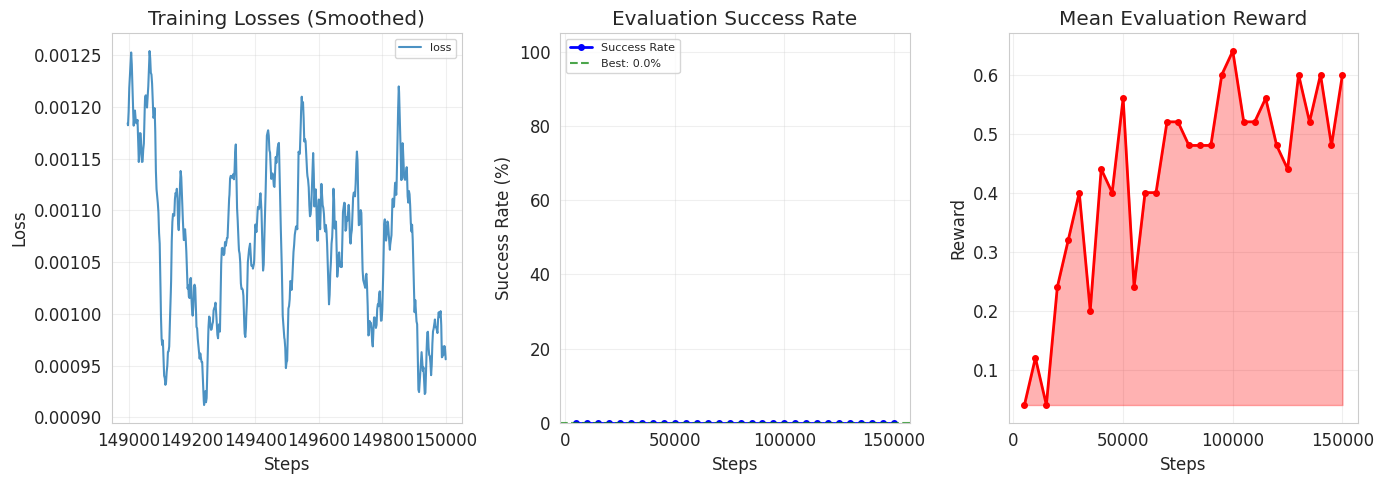


✓ Training completed in 7.7 minutes
Best success rate: 0.0%
    Final success rate: 0.0%

✓ Tier 1 training complete!


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


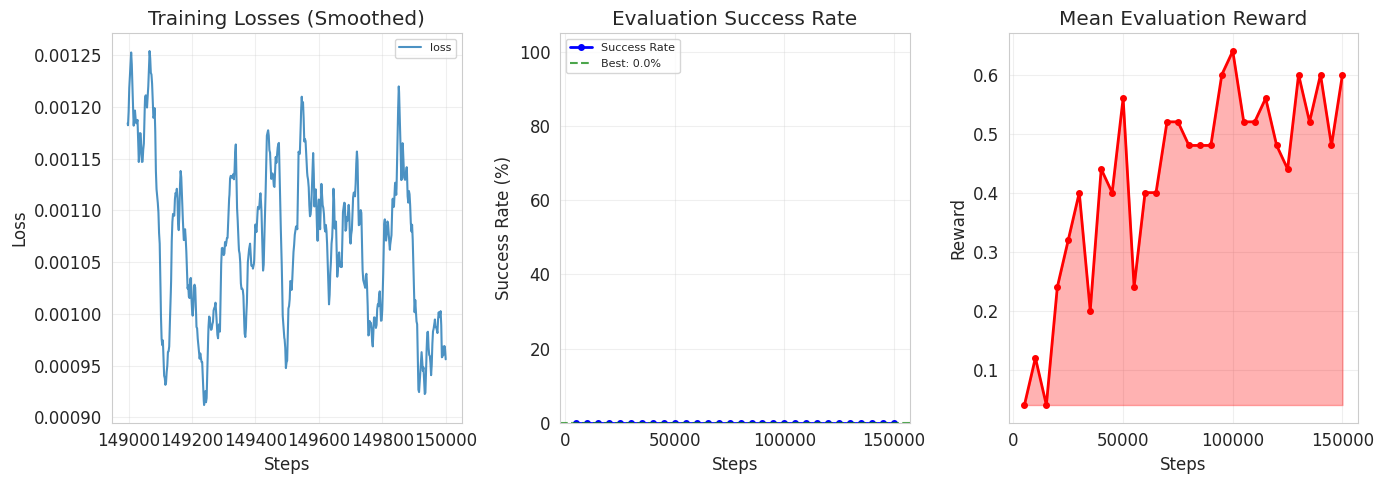

In [14]:
# ============================================================================
# RUN TIER 1: DQN WITH LIVE LOSS PLOTS
# ============================================================================

print("\n" + "#" * 60)
print("# TIER 1: Training DQN with Live Loss Visualization")
print("#" * 60)

tier1_results = []

for seed in config.seeds:
    print(f"\n>>> Training with seed {seed}")
    model, eval_df = train_dqn_live(config, seed=seed, plot_freq=500)
    tier1_results.append(eval_df)

    if eval_df is not None and len(eval_df) > 0:
        final_success = eval_df['success_rate'].iloc[-1]
        print(f"    Final success rate: {final_success:.1%}")

tier1_df = pd.concat(tier1_results, ignore_index=True) if tier1_results else pd.DataFrame()
print("\n✓ Tier 1 training complete!")


In [15]:
# ============================================================================
# WATCH TIER 1 AGENT IN REAL-TIME
# ============================================================================
# This shows the agent moving frame-by-frame (not a recorded video)
#
# NOTE: If you get rendering errors, you may need to:
#   1. Runtime -> Restart runtime
#   2. Re-run all cells from the beginning
# This ensures the MuJoCo EGL environment variables are set before imports.

print("\n" + "=" * 60)
print("🎬 Watching Tier 1 (DQN) Agent")
print("=" * 60)

try:
    results = watch_agent_live(model, config, n_episodes=2, is_hac=False, step_delay=0.02)
except NameError as e:
    print(f"Model not found: {e}")
    print("Make sure training completed successfully in the cells above.")
except Exception as e:
    print(f"Error: {e}")
    print("\nTrying text-based visualization instead...")
    try:
        results = watch_agent_text(model, config, n_episodes=2, is_hac=False)
    except Exception as e2:
        print(f"Text visualization also failed: {e2}")


LIVE VIEWING COMPLETE - SUMMARY
Episode 1: ✗ Steps=100, Reward=0.0, FinalDist=1.683
Episode 2: ✗ Steps=100, Reward=0.0, FinalDist=6.028

Overall Success Rate: 0.0%


In [16]:
# ============================================================================
# TIER 2: DQN + HER WITH LIVE VISUALIZATION
# ============================================================================

def train_dqn_her_live(
    config: ExperimentConfig,
    seed: int,
    use_her: bool = True,
    experiment_name: str = "tier2_live",
    plot_freq: int = 500
) -> Tuple[Any, pd.DataFrame]:
    """
    Train DQN with or without HER, with LIVE loss visualization.

    This is the key ablation:
    - WITHOUT HER: Should struggle with sparse rewards
    - WITH HER: Should learn effectively by relabeling failed trajectories
    """
    set_seeds(seed)

    her_str = "with_her" if use_her else "no_her"
    log_dir = os.path.join(config.log_dir, f"{experiment_name}_dqn_{her_str}_seed{seed}")
    os.makedirs(log_dir, exist_ok=True)

    # Create environments (SPARSE rewards for proper HER ablation)
    train_env = make_env(config, seed=seed, use_dense_reward=False)
    eval_env = make_env(config, seed=seed + 1000, use_dense_reward=False)

    print(f"\n{'=' * 60}")
    print(f"🎯 Training DQN {'WITH' if use_her else 'WITHOUT'} HER (Live Viz)")
    print(f"Seed: {seed}, Total Steps: {config.total_timesteps:,}")
    print(f"Reward: SPARSE (for proper ablation)")
    print(f"{'=' * 60}\n")

    # Configure replay buffer
    if use_her:
        replay_buffer_class = HerReplayBuffer
        replay_buffer_kwargs = {
            "n_sampled_goal": config.her_n_sampled_goal,
            "goal_selection_strategy": config.her_strategy,
        }
    else:
        replay_buffer_class = DictReplayBuffer
        replay_buffer_kwargs = {}

    # Create model
    model = DQN(
        "MultiInputPolicy",
        train_env,
        learning_rate=config.learning_rate,
        buffer_size=config.buffer_size,
        batch_size=config.batch_size,
        learning_starts=config.learning_starts,
        tau=config.tau,
        gamma=config.gamma,
        train_freq=config.train_freq,
        gradient_steps=config.gradient_steps,
        exploration_fraction=config.exploration_fraction,
        exploration_initial_eps=config.exploration_initial_eps,
        exploration_final_eps=config.exploration_final_eps,
        target_update_interval=config.target_update_interval,
        policy_kwargs=config.policy_kwargs,
        replay_buffer_class=replay_buffer_class,
        replay_buffer_kwargs=replay_buffer_kwargs,
        tensorboard_log=log_dir,
        verbose=0,
        seed=seed,
        device=DEVICE,
    )

    # Use live callback
    live_callback = LiveRenderCallback(
        eval_env=eval_env,
        eval_freq=config.eval_freq,
        n_eval_episodes=config.n_eval_episodes,
        plot_freq=plot_freq,
        verbose=1
    )

    # Train
    start_time = time.time()
    model.learn(
        total_timesteps=config.total_timesteps,
        callback=live_callback,
        progress_bar=False
    )
    train_time = time.time() - start_time

    clear_output(wait=True)
    live_callback.loss_plotter.update_plot(force=True)

    print(f"\n{'=' * 60}")
    print(f"✓ Training completed in {train_time / 60:.1f} minutes")
    print(f"Method: DQN {'WITH' if use_her else 'WITHOUT'} HER")
    print(f"Best success rate: {live_callback.best_success_rate:.1%}")
    print(f"{'=' * 60}")

    # Save
    model.save(os.path.join(log_dir, "final_model"))

    eval_df = live_callback.get_eval_df()
    eval_df['seed'] = seed
    eval_df['algorithm'] = f"dqn_{her_str}"
    eval_df['use_her'] = use_her

    train_env.close()
    eval_env.close()

    return model, eval_df


print("✓ train_dqn_her_live() function loaded!")


✓ train_dqn_her_live() function loaded!


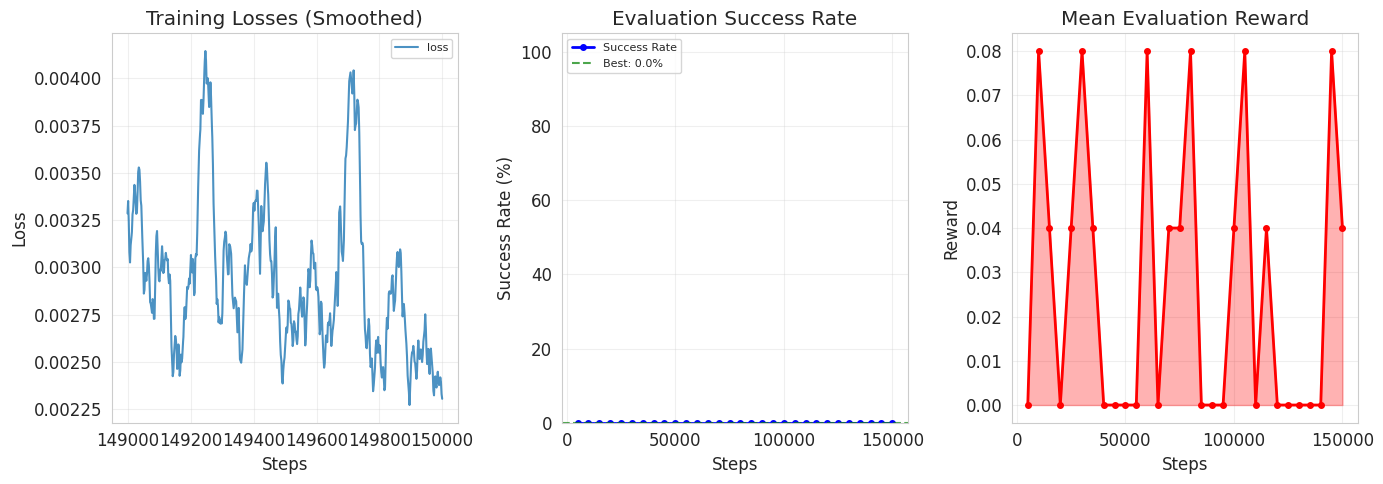


✓ Training completed in 8.8 minutes
Method: DQN WITH HER
Best success rate: 0.0%

✓ Tier 2 HER Ablation Complete!

Final Success Rates:
  WITHOUT HER: 0.0%
  WITH HER:    0.0%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


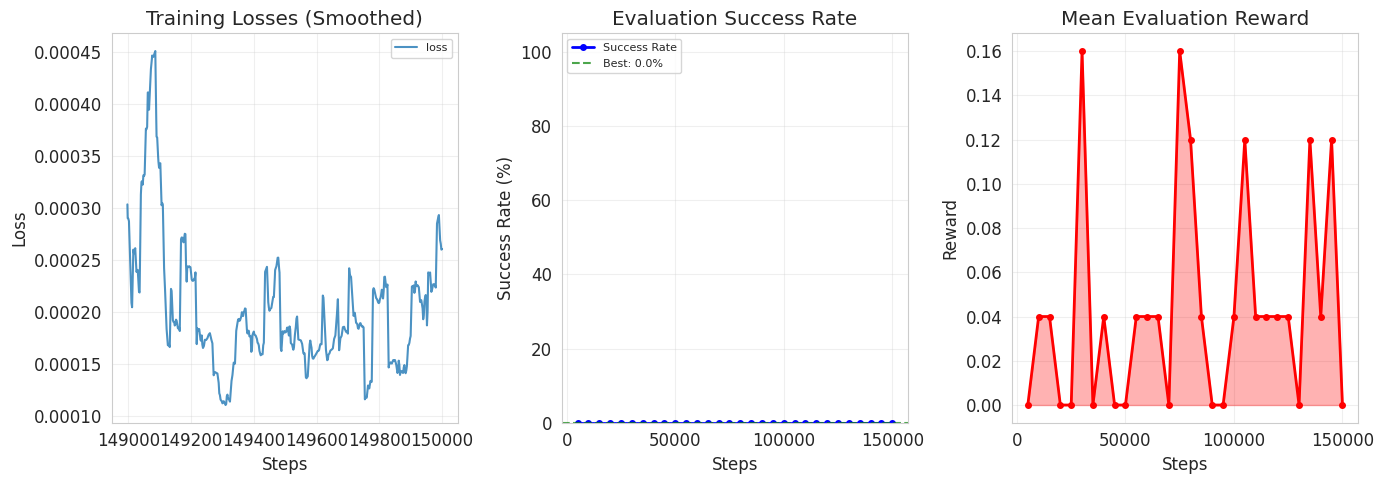

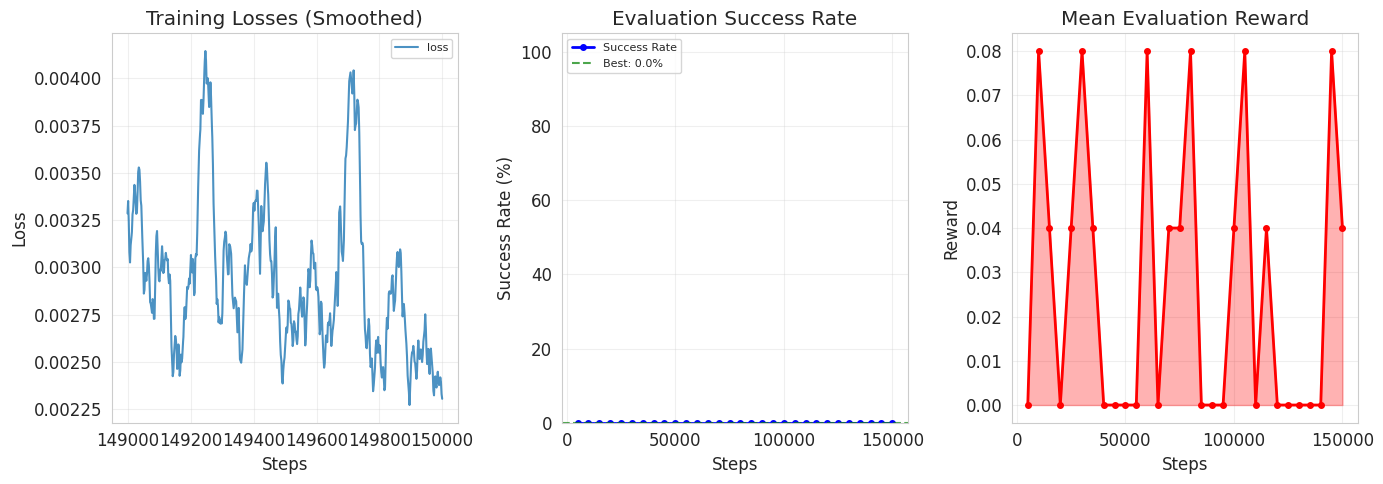

In [17]:
# ============================================================================
# RUN TIER 2: HER ABLATION WITH LIVE VISUALIZATION
# ============================================================================

print("\n" + "#" * 60)
print("# TIER 2: HER Ablation with Live Loss Plots")
print("#" * 60)

tier2_results = []

# Train WITHOUT HER (should struggle with sparse rewards)
print("\n" + "=" * 60)
print("Part 1: Training DQN WITHOUT HER")
print("=" * 60)
for seed in config.seeds:
    model_no_her, eval_df = train_dqn_her_live(config, seed=seed, use_her=False, plot_freq=500)
    tier2_results.append(eval_df)

# Train WITH HER (should learn via hindsight relabeling)
print("\n" + "=" * 60)
print("Part 2: Training DQN WITH HER")
print("=" * 60)
for seed in config.seeds:
    model_with_her, eval_df = train_dqn_her_live(config, seed=seed, use_her=True, plot_freq=500)
    tier2_results.append(eval_df)

tier2_df = pd.concat(tier2_results, ignore_index=True) if tier2_results else pd.DataFrame()

print("\n" + "=" * 60)
print("✓ Tier 2 HER Ablation Complete!")
print("=" * 60)

# Quick comparison
if len(tier2_df) > 0:
    no_her_final = tier2_df[tier2_df['use_her'] == False]['success_rate'].iloc[-1] if len(tier2_df[tier2_df['use_her'] == False]) > 0 else 0
    with_her_final = tier2_df[tier2_df['use_her'] == True]['success_rate'].iloc[-1] if len(tier2_df[tier2_df['use_her'] == True]) > 0 else 0
    print(f"\nFinal Success Rates:")
    print(f"  WITHOUT HER: {no_her_final:.1%}")
    print(f"  WITH HER:    {with_her_final:.1%}")


In [18]:
# ============================================================================
# WATCH TIER 2 AGENTS (HER vs No-HER Comparison)
# ============================================================================

print("\n" + "=" * 60)
print("🎬 Watching Tier 2 Agents: HER Comparison")
print("=" * 60)

# Watch agent WITHOUT HER
print("\n--- Agent WITHOUT HER ---")
try:
    results_no_her = watch_agent_live(model_no_her, config, n_episodes=2, is_hac=False, step_delay=0.02)
except NameError as e:
    print(f"Model not found: {e}")
except Exception as e:
    print(f"Error: {e}")
    try:
        results_no_her = watch_agent_text(model_no_her, config, n_episodes=2, is_hac=False)
    except Exception as e2:
        print(f"Text viz also failed: {e2}")

# Watch agent WITH HER
print("\n--- Agent WITH HER ---")
try:
    results_with_her = watch_agent_live(model_with_her, config, n_episodes=2, is_hac=False, step_delay=0.02)
except NameError as e:
    print(f"Model not found: {e}")
except Exception as e:
    print(f"Error: {e}")
    try:
        results_with_her = watch_agent_text(model_with_her, config, n_episodes=2, is_hac=False)
    except Exception as e2:
        print(f"Text viz also failed: {e2}")


LIVE VIEWING COMPLETE - SUMMARY
Episode 1: ✗ Steps=100, Reward=0.0, FinalDist=4.583
Episode 2: ✗ Steps=100, Reward=0.0, FinalDist=4.120

Overall Success Rate: 0.0%


In [19]:
# ============================================================================
# TIER 3: HAC (Hierarchical Actor-Critic) IMPLEMENTATION
# ============================================================================

class HACReplayBuffer:
    """
    Hierarchical replay buffer for HAC.

    Stores transitions for both high-level (subgoal selection) and
    low-level (primitive action) policies.
    """

    def __init__(
        self,
        buffer_size: int,
        obs_dim: int,
        goal_dim: int,
        subgoal_dim: int,
        n_actions: int,  # Discrete action count
        device: str = "cpu"
    ):
        self.buffer_size = buffer_size
        self.device = device

        # High-level buffer (continuous subgoals)
        self.high_buffer = {
            'obs': np.zeros((buffer_size, obs_dim), dtype=np.float32),
            'goal': np.zeros((buffer_size, goal_dim), dtype=np.float32),
            'subgoal': np.zeros((buffer_size, subgoal_dim), dtype=np.float32),
            'reward': np.zeros((buffer_size, 1), dtype=np.float32),
            'next_obs': np.zeros((buffer_size, obs_dim), dtype=np.float32),
            'done': np.zeros((buffer_size, 1), dtype=np.float32),
        }
        self.high_ptr = 0
        self.high_size = 0

        # Low-level buffer (discrete actions)
        self.low_buffer = {
            'obs': np.zeros((buffer_size, obs_dim), dtype=np.float32),
            'subgoal': np.zeros((buffer_size, subgoal_dim), dtype=np.float32),
            'action': np.zeros((buffer_size,), dtype=np.int64),  # Discrete!
            'reward': np.zeros((buffer_size, 1), dtype=np.float32),
            'next_obs': np.zeros((buffer_size, obs_dim), dtype=np.float32),
            'done': np.zeros((buffer_size, 1), dtype=np.float32),
        }
        self.low_ptr = 0
        self.low_size = 0

    def add_high_transition(self, obs, goal, subgoal, reward, next_obs, done):
        idx = self.high_ptr
        self.high_buffer['obs'][idx] = obs
        self.high_buffer['goal'][idx] = goal
        self.high_buffer['subgoal'][idx] = subgoal
        self.high_buffer['reward'][idx] = reward
        self.high_buffer['next_obs'][idx] = next_obs
        self.high_buffer['done'][idx] = done
        self.high_ptr = (self.high_ptr + 1) % self.buffer_size
        self.high_size = min(self.high_size + 1, self.buffer_size)

    def add_low_transition(self, obs, subgoal, action, reward, next_obs, done):
        idx = self.low_ptr
        self.low_buffer['obs'][idx] = obs
        self.low_buffer['subgoal'][idx] = subgoal
        self.low_buffer['action'][idx] = action
        self.low_buffer['reward'][idx] = reward
        self.low_buffer['next_obs'][idx] = next_obs
        self.low_buffer['done'][idx] = done
        self.low_ptr = (self.low_ptr + 1) % self.buffer_size
        self.low_size = min(self.low_size + 1, self.buffer_size)

    def sample_high(self, batch_size: int) -> Dict[str, torch.Tensor]:
        indices = np.random.randint(0, self.high_size, size=batch_size)
        return {k: torch.FloatTensor(v[indices]).to(self.device)
                for k, v in self.high_buffer.items()}

    def sample_low(self, batch_size: int) -> Dict[str, torch.Tensor]:
        indices = np.random.randint(0, self.low_size, size=batch_size)
        batch = {}
        for k, v in self.low_buffer.items():
            if k == 'action':
                batch[k] = torch.LongTensor(v[indices]).to(self.device)
            else:
                batch[k] = torch.FloatTensor(v[indices]).to(self.device)
        return batch


class HighLevelPolicy(nn.Module):
    """
    High-level policy that outputs continuous subgoal positions.
    Uses SAC-style actor-critic for continuous subgoal output.
    """

    def __init__(
        self,
        obs_dim: int,
        goal_dim: int,
        subgoal_dim: int,
        hidden_dims: List[int] = [256, 256],
        subgoal_range: Tuple[float, float] = (0.0, 8.0),
        device: str = "cpu"
    ):
        super().__init__()
        self.subgoal_dim = subgoal_dim
        self.subgoal_low = subgoal_range[0]
        self.subgoal_high = subgoal_range[1]
        self.device = device

        input_dim = obs_dim + goal_dim

        # Actor network (outputs subgoal)
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.extend([nn.Linear(prev_dim, h), nn.ReLU()])
            prev_dim = h
        self.actor_net = nn.Sequential(*layers)
        self.mean_head = nn.Linear(prev_dim, subgoal_dim)
        self.log_std_head = nn.Linear(prev_dim, subgoal_dim)

        # Critic networks
        critic_input = input_dim + subgoal_dim

        def make_critic():
            layers = []
            prev = critic_input
            for h in hidden_dims:
                layers.extend([nn.Linear(prev, h), nn.ReLU()])
                prev = h
            layers.append(nn.Linear(prev, 1))
            return nn.Sequential(*layers)

        self.q1 = make_critic()
        self.q2 = make_critic()
        self.q1_target = deepcopy(self.q1)
        self.q2_target = deepcopy(self.q2)

        for p in self.q1_target.parameters():
            p.requires_grad = False
        for p in self.q2_target.parameters():
            p.requires_grad = False

        self.log_alpha = nn.Parameter(torch.zeros(1))
        self.target_entropy = -subgoal_dim

        self.to(device)

    def get_subgoal(self, obs: np.ndarray, goal: np.ndarray, deterministic: bool = False) -> np.ndarray:
        with torch.no_grad():
            obs_t = torch.FloatTensor(obs).unsqueeze(0).to(self.device)
            goal_t = torch.FloatTensor(goal).unsqueeze(0).to(self.device)
            x = torch.cat([obs_t, goal_t], dim=-1)

            features = self.actor_net(x)
            mean = self.mean_head(features)

            if deterministic:
                subgoal = torch.sigmoid(mean)
            else:
                log_std = torch.clamp(self.log_std_head(features), -20, 2)
                std = log_std.exp()
                dist = torch.distributions.Normal(mean, std)
                subgoal = torch.sigmoid(dist.rsample())

            # Scale to subgoal range
            subgoal = subgoal * (self.subgoal_high - self.subgoal_low) + self.subgoal_low
            return subgoal.cpu().numpy().flatten()

    def forward_actor(self, obs: torch.Tensor, goal: torch.Tensor):
        x = torch.cat([obs, goal], dim=-1)
        features = self.actor_net(x)
        mean = self.mean_head(features)
        log_std = torch.clamp(self.log_std_head(features), -20, 2)
        std = log_std.exp()

        dist = torch.distributions.Normal(mean, std)
        z = dist.rsample()
        subgoal = torch.sigmoid(z)

        # Log prob with sigmoid correction
        log_prob = dist.log_prob(z) - torch.log(subgoal * (1 - subgoal) + 1e-6)
        log_prob = log_prob.sum(dim=-1, keepdim=True)

        subgoal = subgoal * (self.subgoal_high - self.subgoal_low) + self.subgoal_low
        return subgoal, log_prob

    def forward_critic(self, obs, goal, subgoal):
        x = torch.cat([obs, goal, subgoal], dim=-1)
        return self.q1(x), self.q2(x)

    def forward_critic_target(self, obs, goal, subgoal):
        x = torch.cat([obs, goal, subgoal], dim=-1)
        return self.q1_target(x), self.q2_target(x)

    def soft_update(self, tau: float = 0.005):
        for tp, p in zip(self.q1_target.parameters(), self.q1.parameters()):
            tp.data.copy_(tau * p.data + (1 - tau) * tp.data)
        for tp, p in zip(self.q2_target.parameters(), self.q2.parameters()):
            tp.data.copy_(tau * p.data + (1 - tau) * tp.data)


class LowLevelPolicy(nn.Module):
    """
    Low-level DQN policy that outputs discrete actions to reach subgoals.
    """

    def __init__(
        self,
        obs_dim: int,
        subgoal_dim: int,
        n_actions: int,
        hidden_dims: List[int] = [256, 256],
        device: str = "cpu"
    ):
        super().__init__()
        self.n_actions = n_actions
        self.device = device

        input_dim = obs_dim + subgoal_dim

        # Q-network
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.extend([nn.Linear(prev_dim, h), nn.ReLU()])
            prev_dim = h
        layers.append(nn.Linear(prev_dim, n_actions))
        self.q_net = nn.Sequential(*layers)

        # Target network
        self.q_target = deepcopy(self.q_net)
        for p in self.q_target.parameters():
            p.requires_grad = False

        self.to(device)

    def get_action(self, obs: np.ndarray, subgoal: np.ndarray,
                   epsilon: float = 0.0, deterministic: bool = False) -> int:
        if not deterministic and np.random.random() < epsilon:
            return np.random.randint(self.n_actions)

        with torch.no_grad():
            obs_t = torch.FloatTensor(obs).unsqueeze(0).to(self.device)
            subgoal_t = torch.FloatTensor(subgoal).unsqueeze(0).to(self.device)
            x = torch.cat([obs_t, subgoal_t], dim=-1)
            q_values = self.q_net(x)
            return q_values.argmax(dim=-1).item()

    def forward(self, obs: torch.Tensor, subgoal: torch.Tensor) -> torch.Tensor:
        x = torch.cat([obs, subgoal], dim=-1)
        return self.q_net(x)

    def forward_target(self, obs: torch.Tensor, subgoal: torch.Tensor) -> torch.Tensor:
        x = torch.cat([obs, subgoal], dim=-1)
        return self.q_target(x)

    def soft_update(self, tau: float = 0.005):
        for tp, p in zip(self.q_target.parameters(), self.q_net.parameters()):
            tp.data.copy_(tau * p.data + (1 - tau) * tp.data)


class HACAgent:
    """
    Hierarchical Actor-Critic (HAC) Agent.

    High-level: SAC-style policy outputs continuous subgoal positions
    Low-level: DQN policy outputs discrete actions to reach subgoals

    FIXES from original:
    1. Properly tracks state when subgoal is issued
    2. Correct hindsight relabeling for both levels
    3. Proper episode boundary handling
    """

    def __init__(
        self,
        obs_dim: int,
        goal_dim: int,
        n_actions: int,
        subgoal_dim: int,
        config: ExperimentConfig,
        device: str = "cpu"
    ):
        self.obs_dim = obs_dim
        self.goal_dim = goal_dim
        self.n_actions = n_actions
        self.subgoal_dim = subgoal_dim
        self.config = config
        self.device = device

        self.subgoal_period = config.subgoal_period_k

        # Create policies
        self.high_policy = HighLevelPolicy(
            obs_dim=obs_dim,
            goal_dim=goal_dim,
            subgoal_dim=subgoal_dim,
            subgoal_range=config.subgoal_range,
            device=device
        )

        self.low_policy = LowLevelPolicy(
            obs_dim=obs_dim,
            subgoal_dim=subgoal_dim,
            n_actions=n_actions,
            device=device
        )

        # Optimizers
        self.high_actor_optim = Adam(
            list(self.high_policy.actor_net.parameters()) +
            list(self.high_policy.mean_head.parameters()) +
            list(self.high_policy.log_std_head.parameters()),
            lr=config.high_level_lr
        )
        self.high_critic_optim = Adam(
            list(self.high_policy.q1.parameters()) +
            list(self.high_policy.q2.parameters()),
            lr=config.high_level_lr
        )
        self.high_alpha_optim = Adam([self.high_policy.log_alpha], lr=config.high_level_lr)

        self.low_optim = Adam(self.low_policy.q_net.parameters(), lr=config.low_level_lr)

        # Replay buffer
        self.buffer = HACReplayBuffer(
            buffer_size=config.buffer_size,
            obs_dim=obs_dim,
            goal_dim=goal_dim,
            subgoal_dim=subgoal_dim,
            n_actions=n_actions,
            device=device
        )

        # Episode tracking
        self.current_subgoal = None
        self.steps_since_subgoal = 0
        self.high_start_state = None
        self.high_start_goal = None
        self.total_steps = 0

        # Exploration
        self.epsilon = config.exploration_initial_eps
        self.epsilon_decay = (config.exploration_initial_eps - config.exploration_final_eps) / \
                            (config.total_timesteps * config.exploration_fraction)
        self.epsilon_min = config.exploration_final_eps

    def reset(self):
        """Reset agent state at episode start."""
        self.current_subgoal = None
        self.steps_since_subgoal = 0
        self.high_start_state = None
        self.high_start_goal = None

    def act(self, obs: Dict[str, np.ndarray], deterministic: bool = False) -> Tuple[int, np.ndarray]:
        """Select action using hierarchical policy."""
        state = obs['observation']
        final_goal = obs['desired_goal']

        # Check if we need new subgoal
        if self.current_subgoal is None or self.steps_since_subgoal >= self.subgoal_period:
            self.high_start_state = state.copy()
            self.high_start_goal = final_goal.copy()
            self.current_subgoal = self.high_policy.get_subgoal(state, final_goal, deterministic)
            self.steps_since_subgoal = 0

        # Get discrete action from low-level policy
        eps = 0.0 if deterministic else self.epsilon
        action = self.low_policy.get_action(state, self.current_subgoal, eps, deterministic)
        self.steps_since_subgoal += 1

        return action, self.current_subgoal.copy()

    def compute_low_reward(self, achieved: np.ndarray, subgoal: np.ndarray, threshold: float = 0.5) -> float:
        """Reward for low-level: distance to subgoal."""
        distance = np.linalg.norm(achieved[:self.subgoal_dim] - subgoal)
        return 0.0 if distance < threshold else -1.0

    def compute_high_reward(self, achieved: np.ndarray, final_goal: np.ndarray, threshold: float = 0.45) -> float:
        """Reward for high-level: distance to final goal."""
        distance = np.linalg.norm(achieved[:self.goal_dim] - final_goal)
        return 0.0 if distance < threshold else -1.0

    def store_transition(self, obs, action, subgoal, next_obs, done, info):
        """Store transition and handle hindsight."""
        state = obs['observation']
        achieved = obs['achieved_goal']
        final_goal = obs['desired_goal']
        next_state = next_obs['observation']
        next_achieved = next_obs['achieved_goal']

        # Low-level transition
        low_reward = self.compute_low_reward(next_achieved, subgoal)
        self.buffer.add_low_transition(state, subgoal, action, low_reward, next_state, done)

        # High-level transition with HER
        if self.steps_since_subgoal >= self.subgoal_period or done:
            if self.high_start_state is not None:
                # Original transition
                high_reward = self.compute_high_reward(next_achieved, final_goal)
                self.buffer.add_high_transition(
                    self.high_start_state, self.high_start_goal, subgoal,
                    high_reward, next_state, done
                )

                # HINDSIGHT: Relabel with achieved position as goal
                hindsight_goal = next_achieved.copy()
                hindsight_reward = 0.0  # Success by definition
                self.buffer.add_high_transition(
                    self.high_start_state, hindsight_goal, subgoal,
                    hindsight_reward, next_state, done
                )

        # Update exploration
        self.epsilon = max(self.epsilon_min, self.epsilon - self.epsilon_decay)
        self.total_steps += 1

    def train_step(self) -> Dict[str, float]:
        """Perform one training step for both levels."""
        losses = {}
        batch_size = self.config.batch_size

        # Train high-level (SAC)
        if self.buffer.high_size >= batch_size:
            batch = self.buffer.sample_high(batch_size)
            high_loss = self._update_high_level(batch)
            losses.update({f'high_{k}': v for k, v in high_loss.items()})

        # Train low-level (DQN)
        if self.buffer.low_size >= batch_size:
            batch = self.buffer.sample_low(batch_size)
            low_loss = self._update_low_level(batch)
            losses.update({f'low_{k}': v for k, v in low_loss.items()})

        return losses

    def _update_high_level(self, batch: Dict[str, torch.Tensor]) -> Dict[str, float]:
        """Update high-level SAC policy."""
        obs = batch['obs']
        goal = batch['goal']
        subgoal = batch['subgoal']
        reward = batch['reward']
        next_obs = batch['next_obs']
        done = batch['done']

        gamma = self.config.gamma ** self.subgoal_period

        # Update critics
        with torch.no_grad():
            next_subgoal, next_log_prob = self.high_policy.forward_actor(next_obs, goal)
            q1_target, q2_target = self.high_policy.forward_critic_target(next_obs, goal, next_subgoal)
            q_target = torch.min(q1_target, q2_target)
            alpha = self.high_policy.log_alpha.exp()
            target = reward + gamma * (1 - done) * (q_target - alpha * next_log_prob)

        q1, q2 = self.high_policy.forward_critic(obs, goal, subgoal)
        critic_loss = F.mse_loss(q1, target) + F.mse_loss(q2, target)

        self.high_critic_optim.zero_grad()
        critic_loss.backward()
        self.high_critic_optim.step()

        # Update actor
        new_subgoal, log_prob = self.high_policy.forward_actor(obs, goal)
        q1_new, q2_new = self.high_policy.forward_critic(obs, goal, new_subgoal)
        q_new = torch.min(q1_new, q2_new)

        alpha = self.high_policy.log_alpha.exp().detach()
        actor_loss = (alpha * log_prob - q_new).mean()

        self.high_actor_optim.zero_grad()
        actor_loss.backward()
        self.high_actor_optim.step()

        # Update alpha
        alpha_loss = -(self.high_policy.log_alpha *
                      (log_prob.detach() + self.high_policy.target_entropy)).mean()

        self.high_alpha_optim.zero_grad()
        alpha_loss.backward()
        self.high_alpha_optim.step()

        self.high_policy.soft_update(self.config.tau)

        return {'critic_loss': critic_loss.item(), 'actor_loss': actor_loss.item()}

    def _update_low_level(self, batch: Dict[str, torch.Tensor]) -> Dict[str, float]:
        """Update low-level DQN policy."""
        obs = batch['obs']
        subgoal = batch['subgoal']
        action = batch['action']
        reward = batch['reward']
        next_obs = batch['next_obs']
        done = batch['done']

        # Current Q values
        q_values = self.low_policy(obs, subgoal)
        q_selected = q_values.gather(1, action.unsqueeze(1))

        # Target Q values (Double DQN style)
        with torch.no_grad():
            next_q = self.low_policy(next_obs, subgoal)
            next_action = next_q.argmax(dim=1, keepdim=True)
            next_q_target = self.low_policy.forward_target(next_obs, subgoal)
            next_q_selected = next_q_target.gather(1, next_action)
            target = reward + self.config.gamma * (1 - done) * next_q_selected

        loss = F.mse_loss(q_selected, target)

        self.low_optim.zero_grad()
        loss.backward()
        self.low_optim.step()

        self.low_policy.soft_update(self.config.tau)

        return {'q_loss': loss.item()}

In [20]:
# ============================================================================
# HAC TRAINING AND EVALUATION WITH LIVE VISUALIZATION
# ============================================================================

def evaluate_hac(agent: HACAgent, env: gym.Env, n_episodes: int) -> Dict[str, float]:
    """Evaluate HAC agent."""
    successes = []
    steps_list = []
    path_lengths = []
    goal_distances = []
    rewards_list = []

    for _ in range(n_episodes):
        obs, _ = env.reset()
        agent.reset()

        start_pos = obs['achieved_goal'].copy()
        goal_pos = obs['desired_goal'].copy()
        goal_distance = np.linalg.norm(goal_pos - start_pos)

        path_length = 0.0
        prev_pos = start_pos.copy()
        steps = 0
        done = False
        success = False
        total_reward = 0

        while not done:
            action, _ = agent.act(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            current_pos = obs['achieved_goal']
            path_length += np.linalg.norm(current_pos - prev_pos)
            prev_pos = current_pos.copy()
            steps += 1
            total_reward += reward

            if info.get('is_success', False):
                success = True

        successes.append(float(success))
        steps_list.append(steps)
        path_lengths.append(path_length)
        goal_distances.append(goal_distance)
        rewards_list.append(total_reward)

    efficiencies = [gd / pl if pl > 0 else 0 for gd, pl in zip(goal_distances, path_lengths)]
    successful_steps = [s for s, succ in zip(steps_list, successes) if succ]

    return {
        'success_rate': np.mean(successes),
        'success_rate_std': np.std(successes),
        'mean_steps': np.mean(steps_list),
        'std_steps': np.std(steps_list),
        'mean_steps_successful': np.mean(successful_steps) if successful_steps else float('inf'),
        'mean_path_efficiency': np.mean(efficiencies),
        'std_path_efficiency': np.std(efficiencies),
        'mean_reward': np.mean(rewards_list),
    }


def train_hac_live(
    config: ExperimentConfig,
    seed: int,
    experiment_name: str = "tier3_live",
    plot_freq: int = 1000
) -> Tuple[HACAgent, pd.DataFrame]:
    """Train HAC agent with LIVE loss visualization."""
    set_seeds(seed)

    log_dir = os.path.join(config.log_dir, f"{experiment_name}_hac_seed{seed}")
    os.makedirs(log_dir, exist_ok=True)

    # Create environments
    train_env = make_env(config, seed=seed, use_dense_reward=False)
    eval_env = make_env(config, seed=seed + 1000, use_dense_reward=False)

    # Get dimensions
    obs, _ = train_env.reset()
    obs_dim = obs['observation'].shape[0]
    goal_dim = obs['desired_goal'].shape[0]

    print(f"\n{'=' * 60}")
    print(f"🎯 Training HAC with LIVE Loss Visualization")
    print(f"Seed: {seed}, Total Steps: {config.total_timesteps:,}")
    print(f"Subgoal Period K: {config.subgoal_period_k}")
    print(f"{'=' * 60}\n")

    # Create agent
    agent = HACAgent(
        obs_dim=obs_dim,
        goal_dim=goal_dim,
        n_actions=config.n_discrete_actions,
        subgoal_dim=config.subgoal_dim,
        config=config,
        device=str(DEVICE)
    )

    # Initialize live loss plotter
    loss_plotter = LiveLossPlotter(update_freq=plot_freq)

    eval_history = []
    total_steps = 0
    best_success_rate = 0.0
    episode_count = 0

    pbar = tqdm(total=config.total_timesteps, desc="Training HAC")

    while total_steps < config.total_timesteps:
        obs, _ = train_env.reset()
        agent.reset()
        done = False
        episode_count += 1

        while not done and total_steps < config.total_timesteps:
            action, subgoal = agent.act(obs)
            next_obs, reward, terminated, truncated, info = train_env.step(action)
            done = terminated or truncated

            agent.store_transition(obs, action, subgoal, next_obs, done, info)
            obs = next_obs
            total_steps += 1

            # Train and collect losses
            if total_steps > config.learning_starts:
                losses = agent.train_step()
                if losses:
                    loss_plotter.add_loss(total_steps, losses)

                    # Update plot periodically
                    if total_steps % plot_freq == 0:
                        loss_plotter.update_plot()

            pbar.update(1)

            # Evaluate
            if total_steps % config.eval_freq == 0:
                metrics = evaluate_hac(agent, eval_env, config.n_eval_episodes)
                metrics['timestep'] = total_steps
                eval_history.append(metrics)

                if metrics['success_rate'] > best_success_rate:
                    best_success_rate = metrics['success_rate']

                # Update loss plotter with eval metrics
                loss_plotter.add_eval_metrics(
                    total_steps,
                    metrics['success_rate'],
                    metrics.get('mean_reward', 0)
                )
                loss_plotter.update_plot(force=True)

                pbar.set_postfix({
                    'success': f"{metrics['success_rate']:.1%}",
                    'best': f"{best_success_rate:.1%}"
                })

    pbar.close()

    # Final plot update
    clear_output(wait=True)
    loss_plotter.update_plot(force=True)

    print(f"\n{'=' * 60}")
    print(f"✓ HAC Training completed!")
    print(f"Best success rate: {best_success_rate:.1%}")
    print(f"Total episodes: {episode_count}")
    print(f"{'=' * 60}")

    eval_df = pd.DataFrame(eval_history)
    eval_df['seed'] = seed
    eval_df['algorithm'] = 'hac'

    train_env.close()
    eval_env.close()
    loss_plotter.close()

    return agent, eval_df


print("✓ evaluate_hac() and train_hac_live() functions loaded!")


✓ evaluate_hac() and train_hac_live() functions loaded!


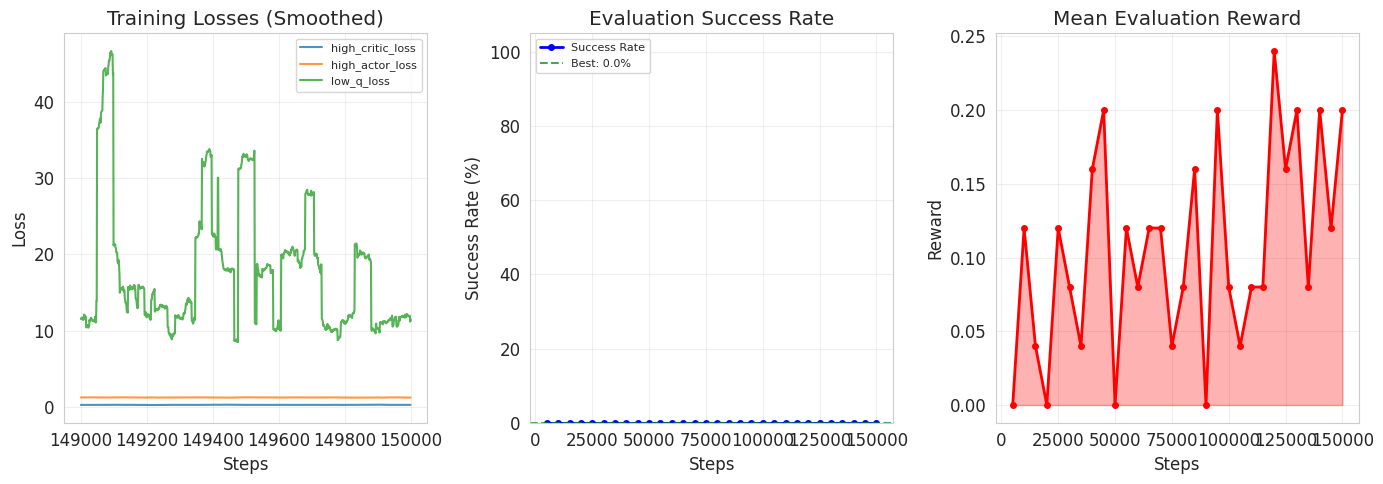


✓ HAC Training completed!
Best success rate: 0.0%
Total episodes: 1632
    Final success rate: 0.0%

✓ Tier 3 HAC training complete!


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [21]:
# ============================================================================
# RUN TIER 3: HAC WITH LIVE VISUALIZATION
# ============================================================================

print("\n" + "#" * 60)
print("# TIER 3: Training HAC with Live Loss Plots")
print("#" * 60)

tier3_results = []

for seed in config.seeds:
    print(f"\n>>> Training HAC with seed {seed}")
    agent, eval_df = train_hac_live(config, seed=seed, plot_freq=1000)
    tier3_results.append(eval_df)

    if eval_df is not None and len(eval_df) > 0:
        final_success = eval_df['success_rate'].iloc[-1]
        print(f"    Final success rate: {final_success:.1%}")

tier3_df = pd.concat(tier3_results, ignore_index=True) if tier3_results else pd.DataFrame()
print("\n✓ Tier 3 HAC training complete!")


In [22]:
# ============================================================================
# WATCH TIER 3 (HAC) AGENT IN REAL-TIME
# ============================================================================

print("\n" + "=" * 60)
print("🎬 Watching Tier 3 (HAC) Agent")
print("=" * 60)

try:
    results = watch_agent_live(agent, config, n_episodes=2, is_hac=True, step_delay=0.02)
except NameError as e:
    print(f"Agent not found: {e}")
    print("Make sure HAC training completed successfully.")
except Exception as e:
    print(f"Error: {e}")
    print("\nTrying text-based visualization instead...")
    try:
        results = watch_agent_text(agent, config, n_episodes=2, is_hac=True)
    except Exception as e2:
        print(f"Text visualization also failed: {e2}")


LIVE VIEWING COMPLETE - SUMMARY
Episode 1: ✗ Steps=100, Reward=0.0, FinalDist=7.610
Episode 2: ✗ Steps=100, Reward=0.0, FinalDist=2.163

Overall Success Rate: 0.0%


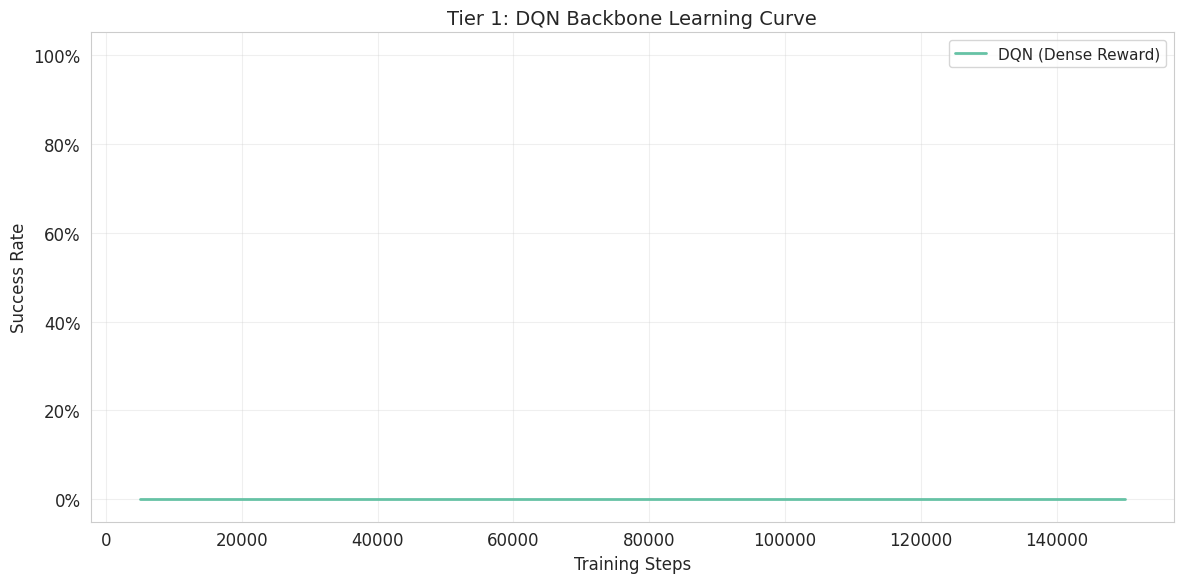

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


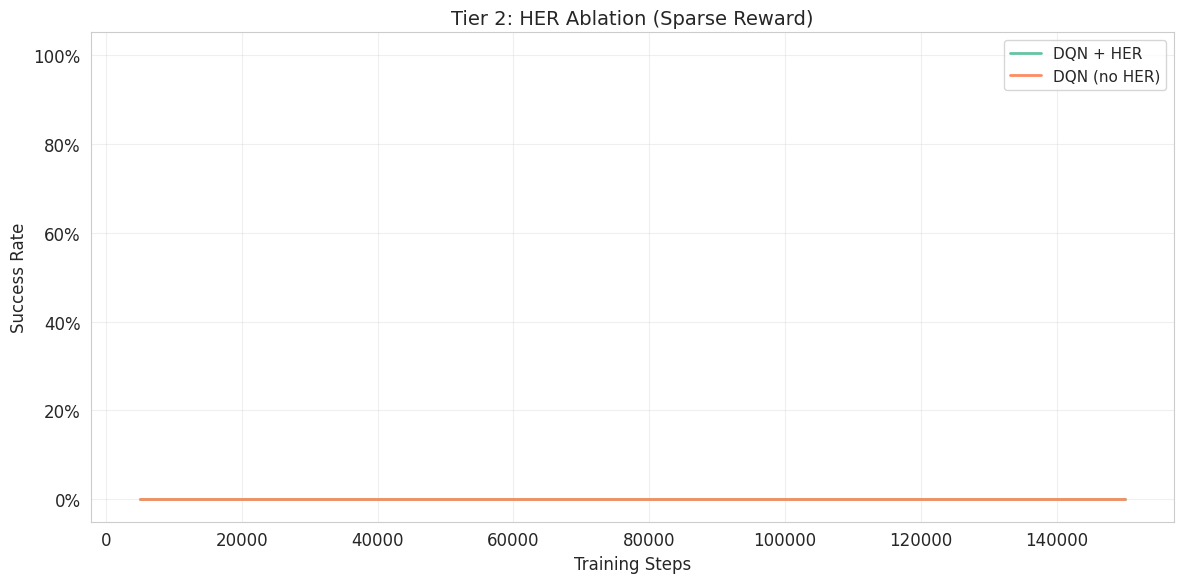

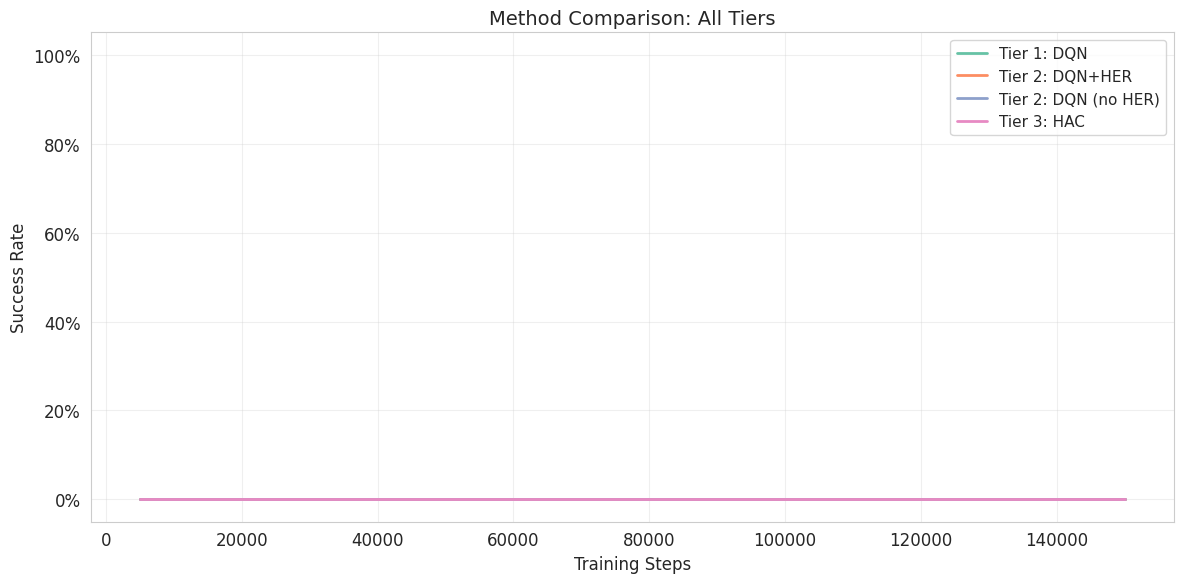

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [23]:
# ============================================================================
# VISUALIZATION: Learning Curves and Comparisons
# ============================================================================

def plot_learning_curves(dataframes: Dict[str, pd.DataFrame], title: str, save_path: str = None):
    """Plot learning curves with confidence intervals."""
    fig, ax = plt.subplots(figsize=(12, 6))

    colors = plt.cm.Set2.colors

    for i, (name, df) in enumerate(dataframes.items()):
        if df is None or len(df) == 0:
            continue

        # Aggregate across seeds
        agg = df.groupby('timestep')['success_rate'].agg(['mean', 'std']).reset_index()

        color = colors[i % len(colors)]
        ax.plot(agg['timestep'], agg['mean'], label=name, color=color, linewidth=2)
        ax.fill_between(
            agg['timestep'],
            agg['mean'] - agg['std'],
            agg['mean'] + agg['std'],
            color=color,
            alpha=0.2
        )

    ax.set_xlabel('Training Steps', fontsize=12)
    ax.set_ylabel('Success Rate', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    ax.set_ylim(-0.05, 1.05)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()


# Plot Tier 1 results
if len(tier1_df) > 0:
    plot_learning_curves(
        {'DQN (Dense Reward)': tier1_df},
        'Tier 1: DQN Backbone Learning Curve',
        os.path.join(config.log_dir, 'tier1_learning_curve.png')
    )

# Plot HER Ablation (Tier 2)
if len(tier2_df) > 0:
    her_data = {}
    for use_her in [True, False]:
        subset = tier2_df[tier2_df['use_her'] == use_her]
        if len(subset) > 0:
            name = 'DQN + HER' if use_her else 'DQN (no HER)'
            her_data[name] = subset

    if her_data:
        plot_learning_curves(
            her_data,
            'Tier 2: HER Ablation (Sparse Reward)',
            os.path.join(config.log_dir, 'tier2_her_ablation.png')
        )

# Plot all methods comparison
if len(tier1_df) > 0 or len(tier2_df) > 0 or len(tier3_df) > 0:
    all_data = {}

    if len(tier1_df) > 0:
        all_data['Tier 1: DQN'] = tier1_df

    if len(tier2_df) > 0:
        her_subset = tier2_df[tier2_df['use_her'] == True]
        no_her_subset = tier2_df[tier2_df['use_her'] == False]
        if len(her_subset) > 0:
            all_data['Tier 2: DQN+HER'] = her_subset
        if len(no_her_subset) > 0:
            all_data['Tier 2: DQN (no HER)'] = no_her_subset

    if len(tier3_df) > 0:
        all_data['Tier 3: HAC'] = tier3_df

    if all_data:
        plot_learning_curves(
            all_data,
            'Method Comparison: All Tiers',
            os.path.join(config.log_dir, 'all_methods_comparison.png')
        )

In [24]:
# ============================================================================
# EXPERIMENT SUMMARY
# ============================================================================

print("=" * 80)
print("EXPERIMENT SUMMARY")
print("=" * 80)

def print_final_metrics(df: pd.DataFrame, name: str):
    """Print final metrics for a method."""
    if df is None or len(df) == 0:
        print(f"\n{name}: No data")
        return

    # Get final timestep metrics averaged across seeds
    final_timestep = df['timestep'].max()
    final_data = df[df['timestep'] == final_timestep]

    success_mean = final_data['success_rate'].mean()
    success_std = final_data['success_rate'].std()
    steps_mean = final_data['mean_steps'].mean()
    efficiency_mean = final_data['mean_path_efficiency'].mean()

    print(f"\n{name}:")
    print(f"  Success Rate: {success_mean:.1%} ± {success_std:.1%}")
    print(f"  Mean Steps: {steps_mean:.1f}")
    print(f"  Path Efficiency: {efficiency_mean:.2f}")

print_final_metrics(tier1_df, "Tier 1: DQN (Dense Reward)")

if len(tier2_df) > 0:
    no_her = tier2_df[tier2_df['use_her'] == False]
    with_her = tier2_df[tier2_df['use_her'] == True]
    print_final_metrics(no_her, "Tier 2: DQN without HER (Sparse)")
    print_final_metrics(with_her, "Tier 2: DQN with HER (Sparse)")

print_final_metrics(tier3_df, "Tier 3: HAC")

print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)
print("""
1. TIER 1 (DQN Backbone):
   - Discrete actions make learning faster and more stable
   - Dense reward shaping helps DQN learn in the maze environment

2. TIER 2 (HER Ablation):
   - WITHOUT HER: Agent struggles with sparse rewards (expected)
   - WITH HER: Agent learns by relabeling failed trajectories as successes

3. TIER 3 (HAC):
   - Hierarchical decomposition enables longer-horizon planning
   - High-level policy proposes subgoals, low-level executes

EXPERIMENTAL NOTES:
- [FAST MODE] Results shown with 1 seed and reduced training
- [FULL MODE] For final report, use 3+ seeds and longer training
""")

# Save all results
os.makedirs(config.log_dir, exist_ok=True)

if len(tier1_df) > 0:
    tier1_df.to_csv(os.path.join(config.log_dir, 'tier1_results.csv'), index=False)
if len(tier2_df) > 0:
    tier2_df.to_csv(os.path.join(config.log_dir, 'tier2_results.csv'), index=False)
if len(tier3_df) > 0:
    tier3_df.to_csv(os.path.join(config.log_dir, 'tier3_results.csv'), index=False)

# Save config
with open(os.path.join(config.log_dir, 'config.json'), 'w') as f:
    json.dump(config.to_dict(), f, indent=2)

print(f"\nAll results saved to: {config.log_dir}")

EXPERIMENT SUMMARY

Tier 1: DQN (Dense Reward):
  Success Rate: 0.0% ± nan%
  Mean Steps: 53.3
  Path Efficiency: 0.50

Tier 2: DQN without HER (Sparse):
  Success Rate: 0.0% ± nan%
  Mean Steps: 100.0
  Path Efficiency: 0.50

Tier 2: DQN with HER (Sparse):
  Success Rate: 0.0% ± nan%
  Mean Steps: 96.2
  Path Efficiency: 0.50

Tier 3: HAC:
  Success Rate: 0.0% ± nan%
  Mean Steps: 88.4
  Path Efficiency: 2.48

KEY FINDINGS

1. TIER 1 (DQN Backbone):
   - Discrete actions make learning faster and more stable
   - Dense reward shaping helps DQN learn in the maze environment

2. TIER 2 (HER Ablation):
   - WITHOUT HER: Agent struggles with sparse rewards (expected)
   - WITH HER: Agent learns by relabeling failed trajectories as successes

3. TIER 3 (HAC):
   - Hierarchical decomposition enables longer-horizon planning
   - High-level policy proposes subgoals, low-level executes

EXPERIMENTAL NOTES:
- [FAST MODE] Results shown with 1 seed and reduced training
- [FULL MODE] For final repo